In [171]:
'''Line up the peak
Interpolation that taken account in the non-uniform timestep? --DONE
Feed the output back as input to see anything reasonable
Try multiple band?
See see the output from the encoding part
Philips relation from the output'''

'Line up the peak\nInterpolation that taken account in the non-uniform timestep? --DONE\nFeed the output back as input to see anything reasonable\nTry multiple band?\nSee see the output from the encoding part\nPhilips relation from the output'

In [172]:
import os
import glob
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, splrep

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [173]:
# Import the .json file

os.chdir(r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\all_photometry")
filename = glob.glob('*.json')
print(len(filename))

# Create a list for all .json, the 1st SN saved as json_data[0], the 2nd SN saved as json_data[1], etc.
json_data = []
for i in filename:
    with open(i, encoding="utf-8") as f:
        json_data.append(json.load(f))

99


In [174]:
# To obtain absolute magnitude and time in a particular band

Band = [] # Contain EM band chosen for analysis
Magnitude_Abs = [] # Contain absolute magnitude
Time = [] # Contain time (day)
Type = [] # Claimed type

for i in range(len(filename)): # Loop through all SN
    Band.append([]) # Create 2D list
    Magnitude_Abs.append([])
    Time.append([])
    
    SN_name = filename[i].replace('.json', '')
    SN_name = SN_name.replace('_', ':')
    
    Type.append(json_data[i][SN_name]['claimedtype'][0]['value'])
    
    N = len(json_data[i][SN_name]['photometry']) # The no. of data point of photometry in each SN
    
    for j in range(N): # Loop through all photemetry datapoint in one SN
        # Avoid any data point without band data
        try:
            Band[i].append(json_data[i][SN_name]['photometry'][j]['band'])
        except:
            Band[i].append(0)
        
        # Fill the Magnitude_Abs and Time list if the data point is in B band
        if Band[i][j] == 'B':
            Magnitude_App = float(json_data[i][SN_name]['photometry'][j]['magnitude']) # Obtain the apparent magnitude from photometry
            LumDist = float(json_data[i][SN_name]['lumdist'][0]['value']) # Obtain the luminosity distance
            z = float(json_data[i][SN_name]['redshift'][0]['value']) #Obtain the redshift, z
            Magnitude_Abs[i].append(Magnitude_App - 5*np.log10(LumDist*1e5) + 2.5*np.log10(1+z)) # Calculate the absolute magnitude and fill the Magnitude_Abs list
            Time[i].append(float(json_data[i][SN_name]['photometry'][j]['time'])) # Fill the Time list

In [179]:
# Peak fitting

from sklearn.metrics import r2_score
Time_max = [] # Save the day of maximum magnitude
fitting_days = 30 # Num of days after the maximum used for peak fitting from the peak

for i in range(len(filename)): # Loop through all SN
    if len(Time[i]) > 0: # Avoid list with too few data
        maximum = np.argmin(Magnitude_Abs[i]) # Obtain the id of the maximum magnitude
        peak_time = Time[i][maximum] # Save the day of maximum magnitude
        tail_time = Time[i][maximum] # Save the day of the end of the initial lightcurve fall off
        
        # Calculate the day of the end of the initial lightcurve fall off
        j = 0
        if (peak_time + fitting_days) < Time[i][-1]: # Avoid light curve that is too short (fewer than 30 days after the peak)
            while tail_time < (peak_time + fitting_days):
                tail_time = Time[i][maximum + j]
                if tail_time > (peak_time + fitting_days):
                    break
                j += 1
        
        # Save the peaking part of the light curve
        m = Magnitude_Abs[i][:maximum + j]
        t = Time[i][:maximum + j]
        
        # Polynomial (degree = 3) fit of the peak part of the light curve 
        P = np.poly1d(np.polyfit(t, m, deg = 3))
        
        # Save the time of maximum magnitude
        Time_max.append(Time[i][np.argmin(P(t))])
        
print(Time_max)

[57183.26, 28774.2, 41454.83, 44587.13, 44672.97, 47558.94, 48083.99, 49686.49, 49432.48, 50952.87, 51305.0, 51256.28, 51469.1, 51482.43, 51527.48, 51692.38, 51753.4, 51578.75, 52183.34, 51975.55, 52524.4, 52548.49, 52729.24, 52766.68954, 52807.49, 52875.44, 53219.81, 53278.21, 53282.5, 53355.39, 53412.31419, 53436.11336, 53457.95, 53534.33, 53557.82, 53646.46, 53665.912, 53704.97659, 53741.19233, 53827.74723, 53756.93497, 54048.51, 54174.51, 54258.42, 54356.35412, 54365.36091, 54407.8, 54418.8957, 54453.02861, 54469.30411, 54812.6772, 54817.26045, 54830.3408, 54897.46, 54921.99, 55054.4, 55119.18206, 54857.50559, 55455.8, 55691.28, 55764.913, 55815.14, 56011.78, 56082.4087, 56154.22, 56244.193, 56286.3787, 56295.8716, 56350.815, 56344.4666, 56374.24, 56405.452, 56508.84, 56574.9788, 56551.37, 56528.6, 56648.3, 56771.42, 56909.091, 56903.393, 56954.6825, 57107.389, 57125.51, 57034.31, 57548.22, 57511.9571, 57509.082, 57616.3047, 57619.1026, 57710.0343, 57415.92, 57891.36, 57892.02, 579

c:\users\ricky\anaconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


356
99
99
[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
40
[105, 81, 177, 127, 108, 69, 119, 157, 236, 86, 72, 81, 112, 67, 47, 146, 110, 117, 81, 247, 68, 88, 91, 356, 236, 143, 249, 96, 87, 130, 240, 68, 127, 90, 109, 84, 160, 103, 79, 64]
no. of data points is 106
the claimed type is II P


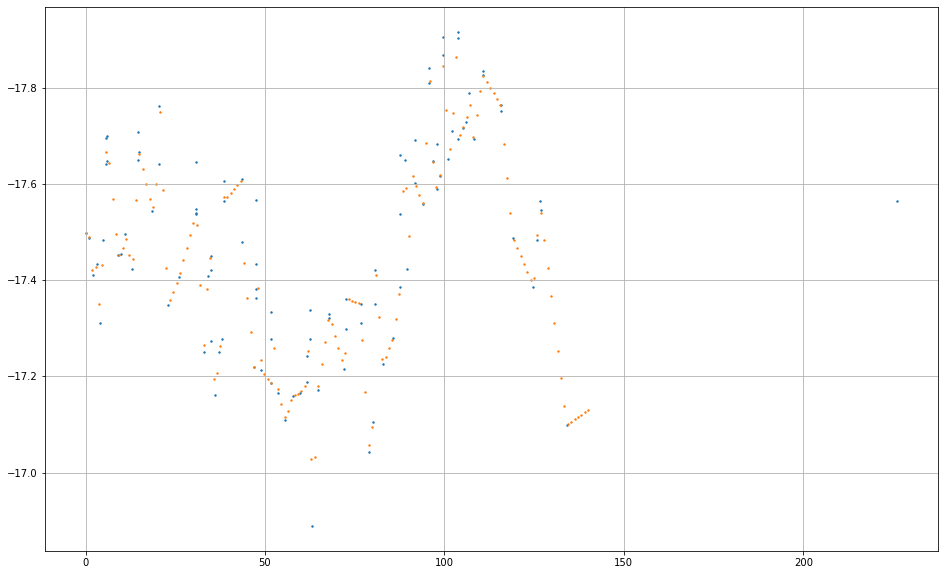

no. of data points is 82
the claimed type is Ia


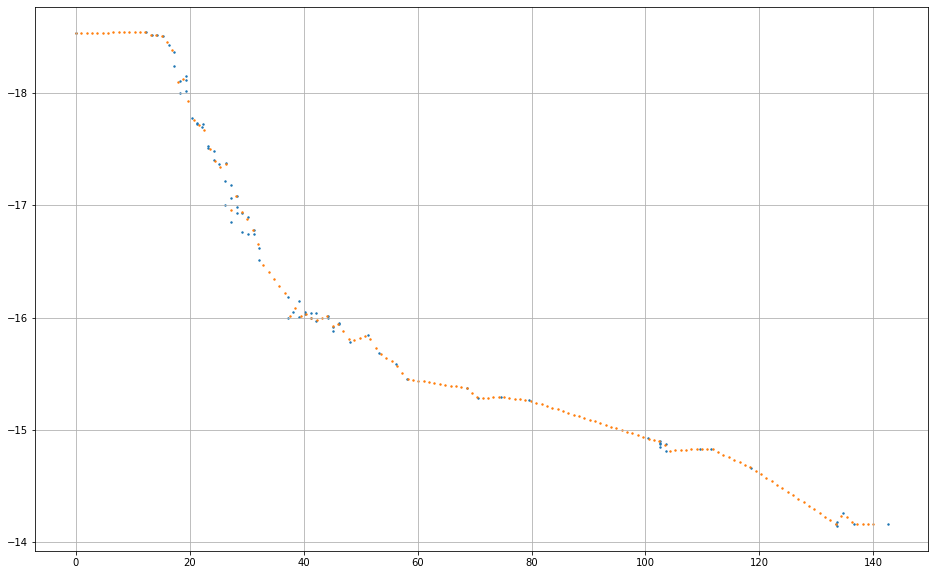

no. of data points is 178
the claimed type is Ia


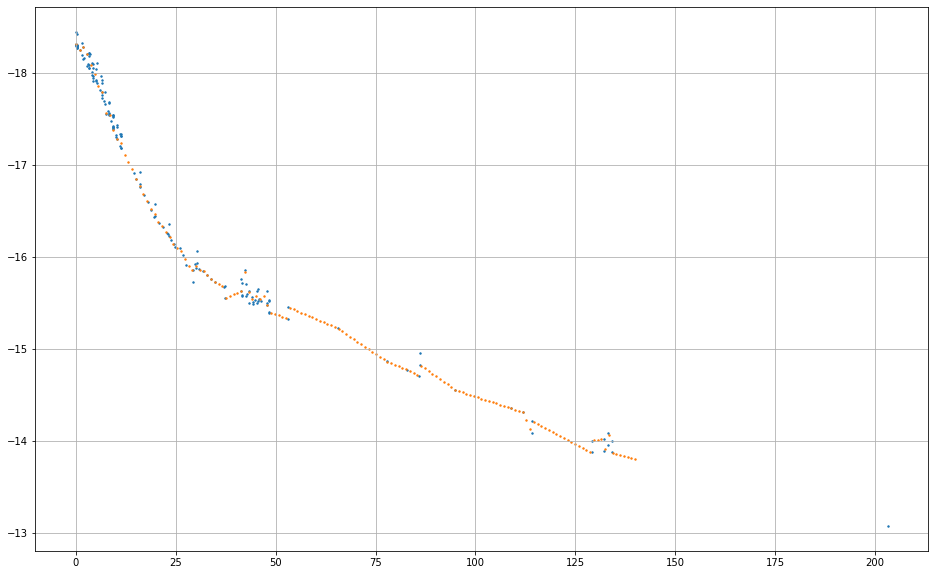

no. of data points is 128
the claimed type is Ia


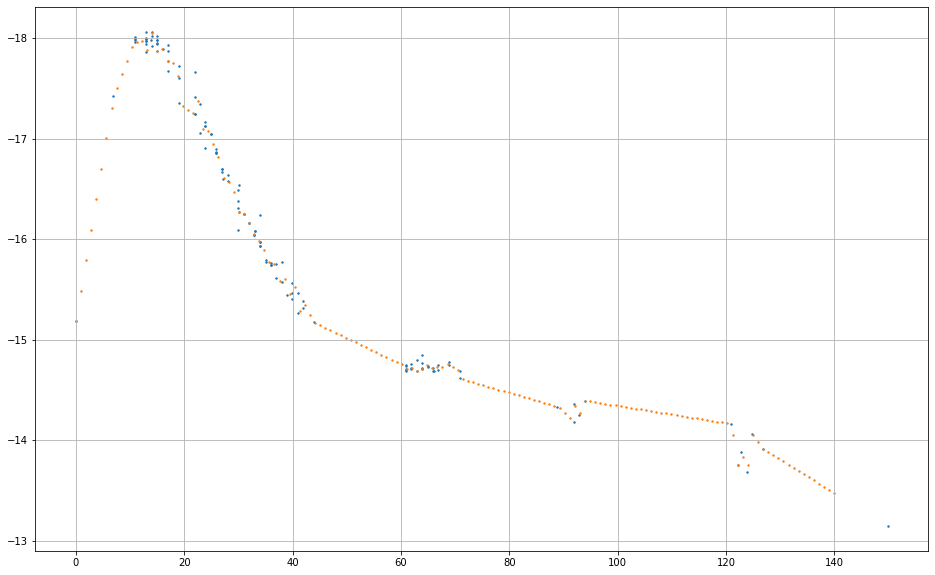

no. of data points is 109
the claimed type is Ia


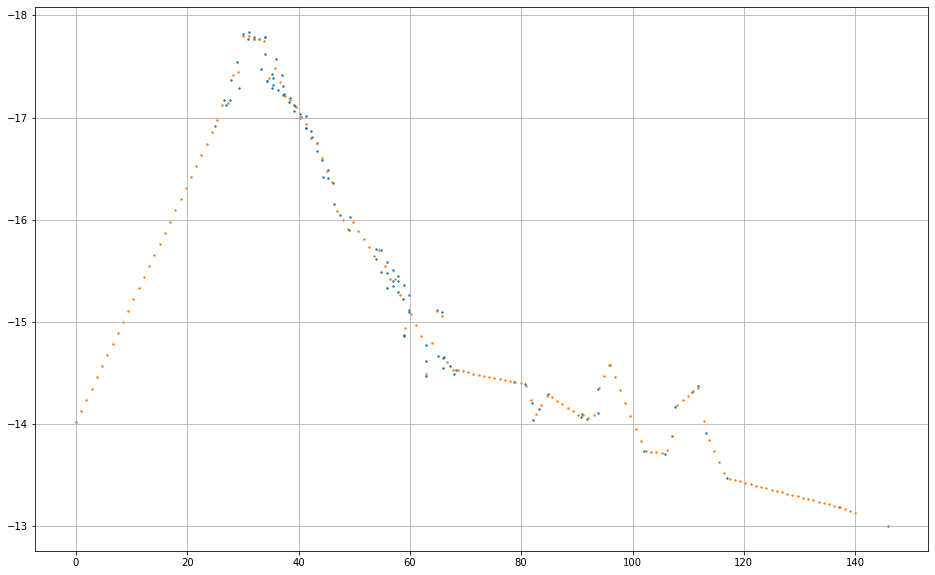

no. of data points is 70
the claimed type is Ia


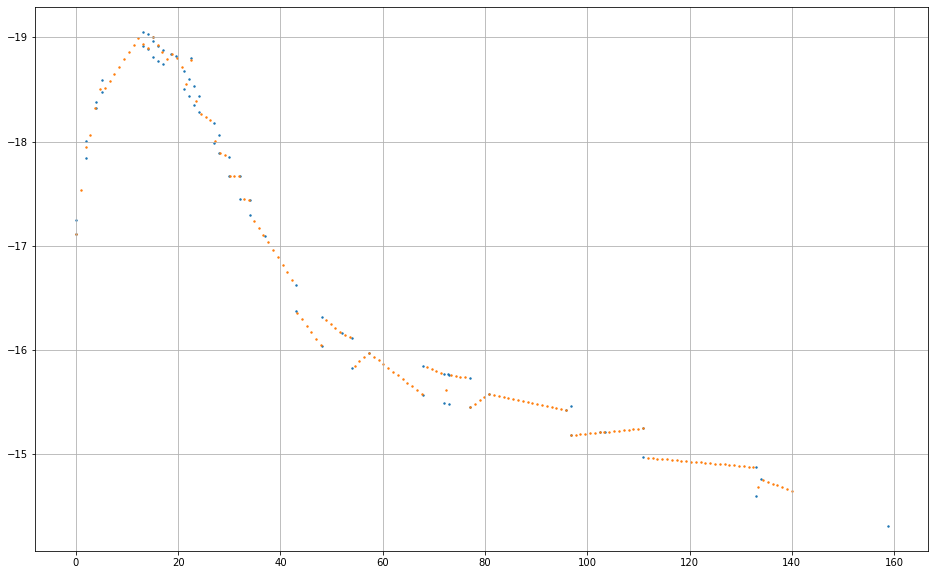

no. of data points is 120
the claimed type is Ia


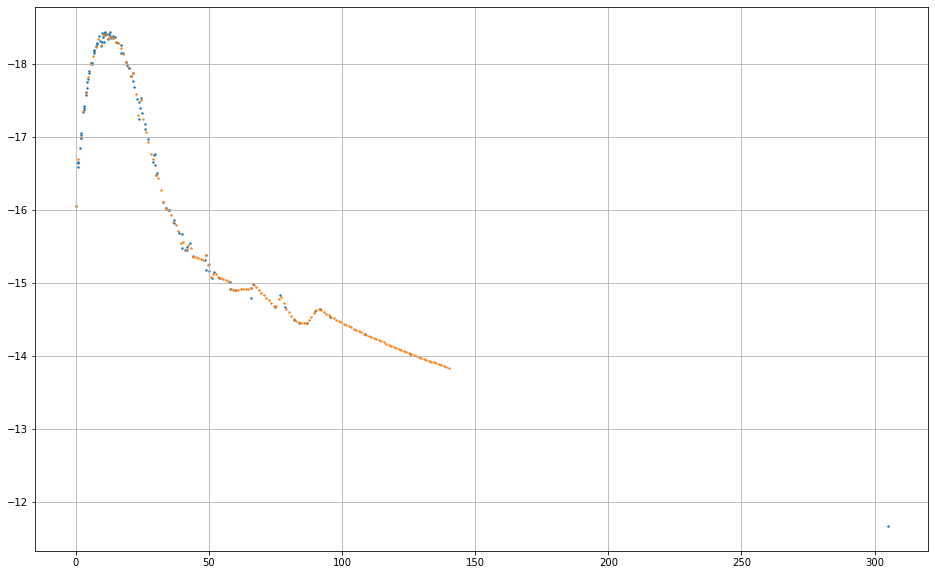

no. of data points is 158
the claimed type is II P


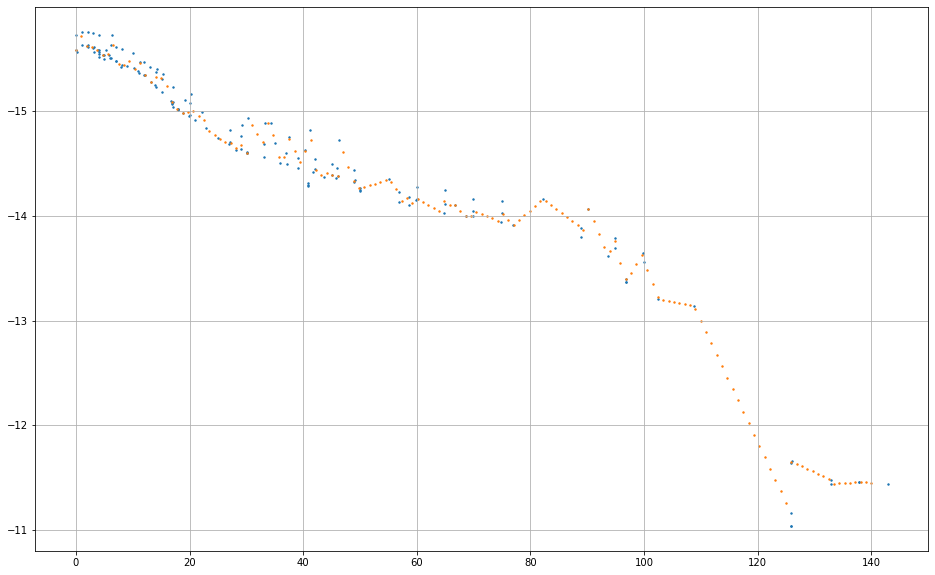

no. of data points is 237
the claimed type is Ia Pec


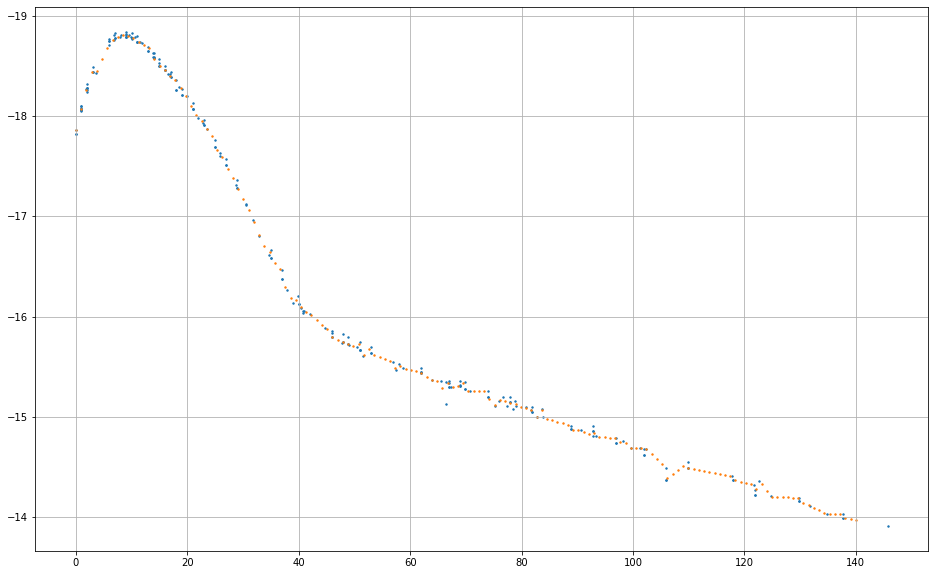

no. of data points is 87
the claimed type is Ia


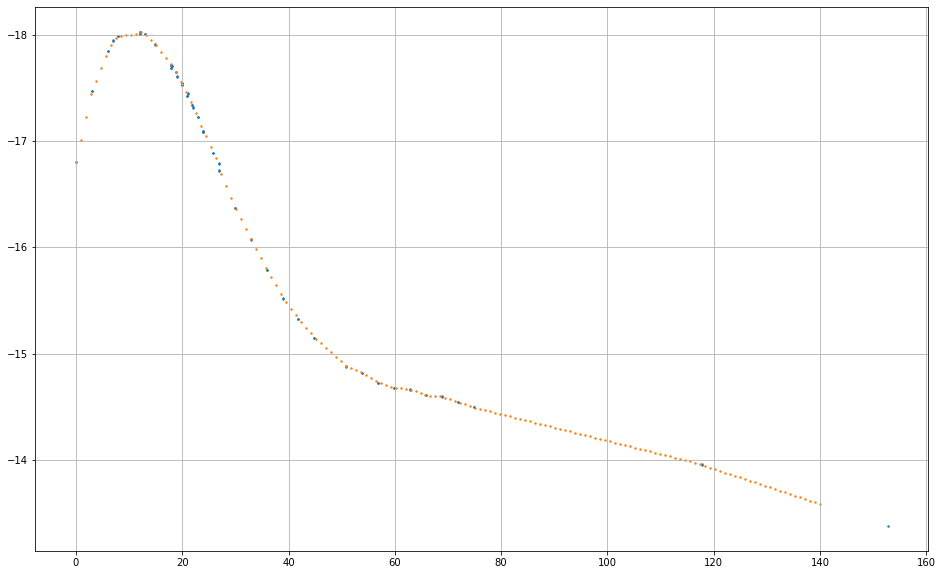

no. of data points is 73
the claimed type is Ia


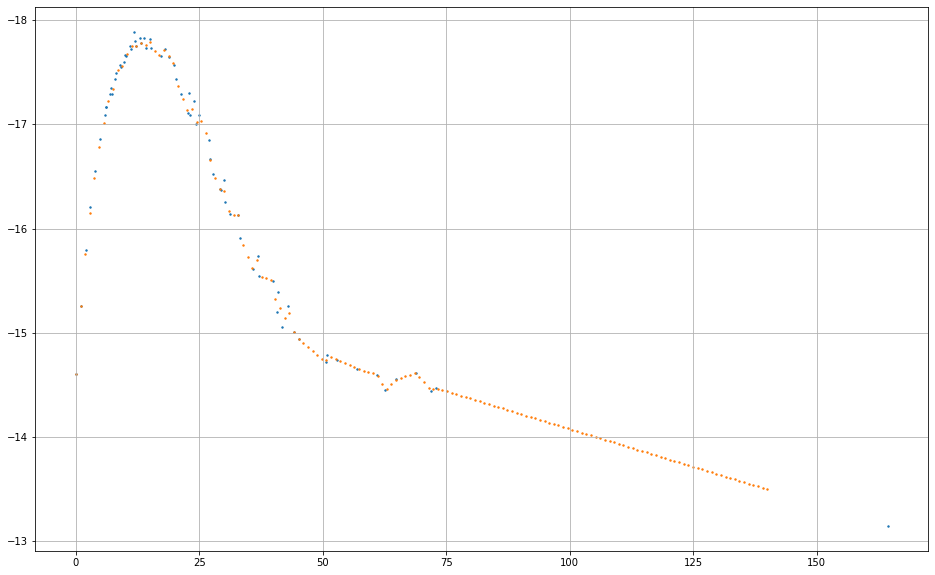

no. of data points is 82
the claimed type is Ia


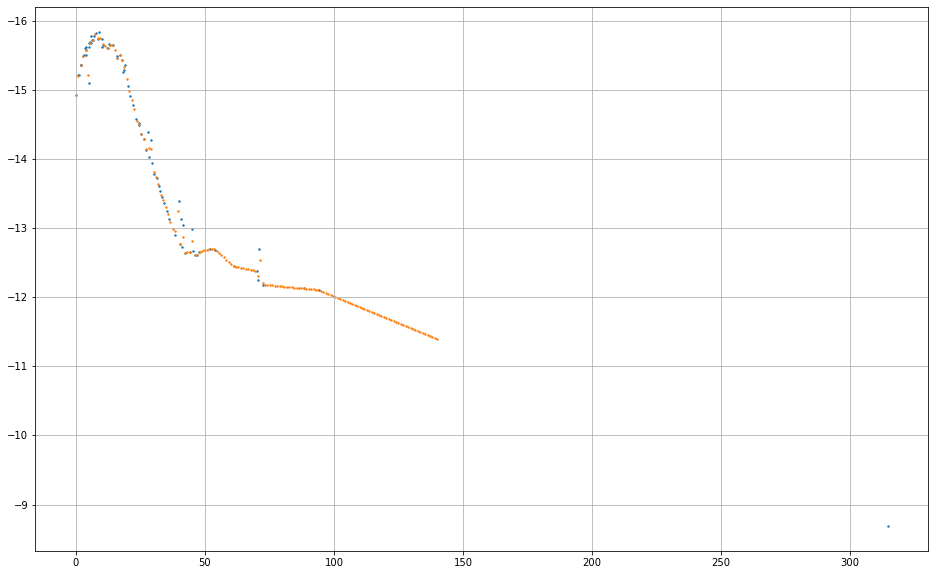

no. of data points is 113
the claimed type is Ia


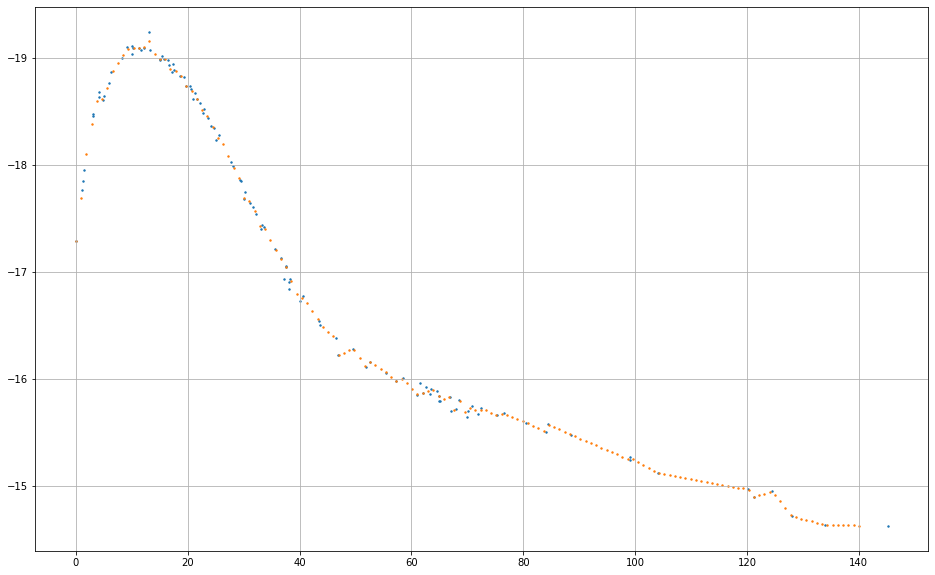

no. of data points is 68
the claimed type is II P


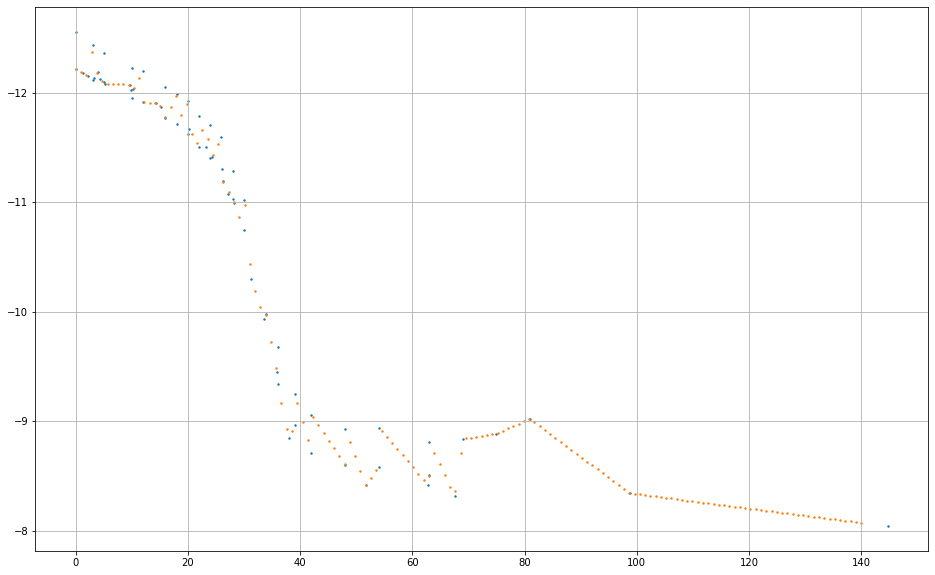

no. of data points is 48
the claimed type is II P


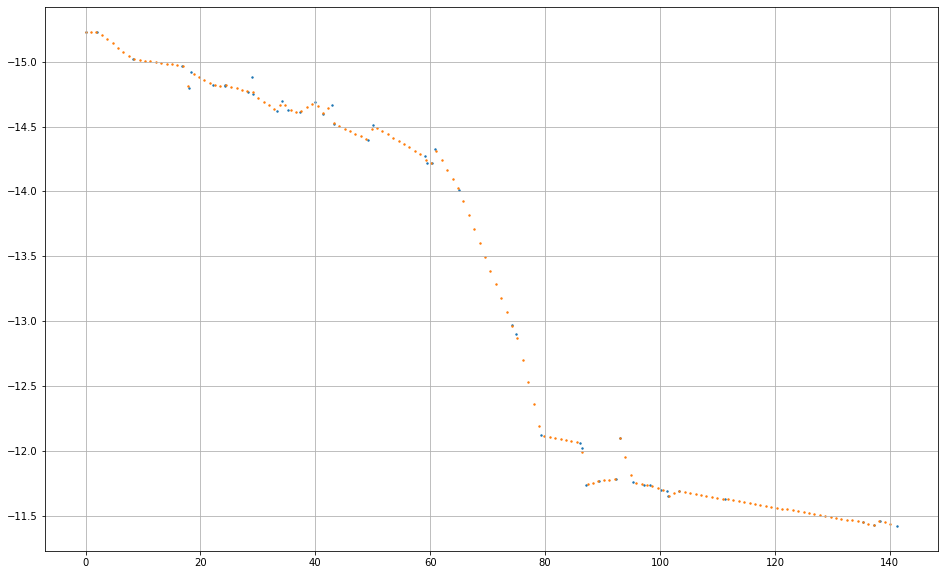

no. of data points is 147
the claimed type is Ia


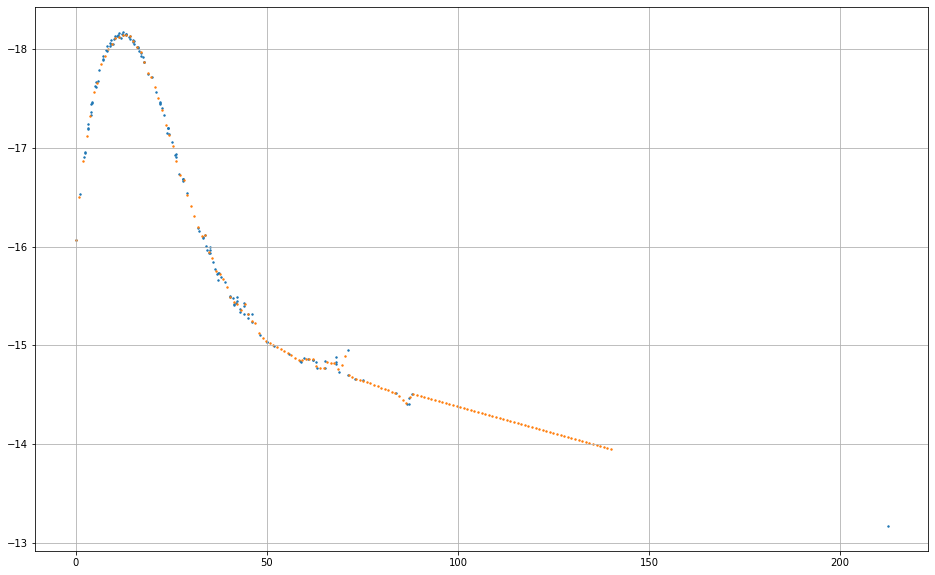

no. of data points is 111
the claimed type is II


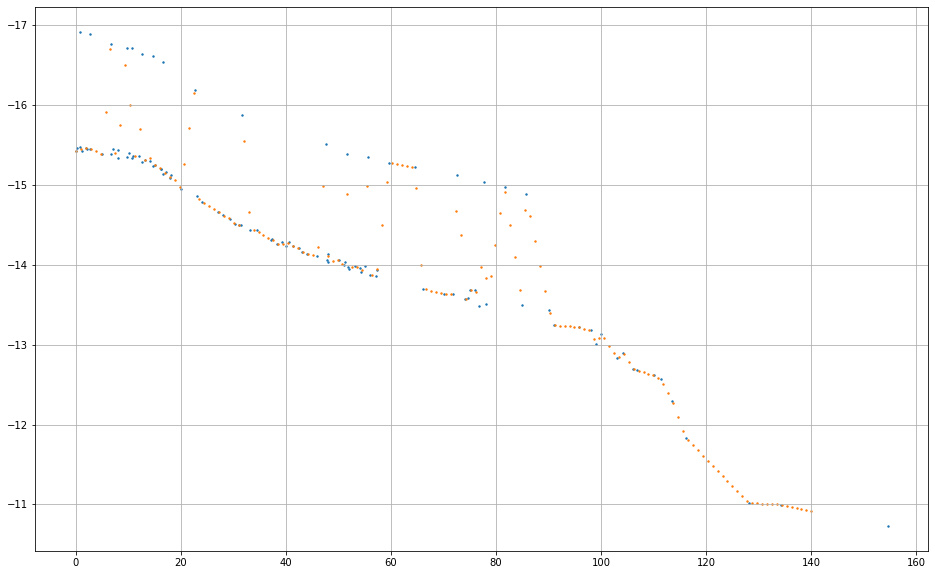

no. of data points is 118
the claimed type is II


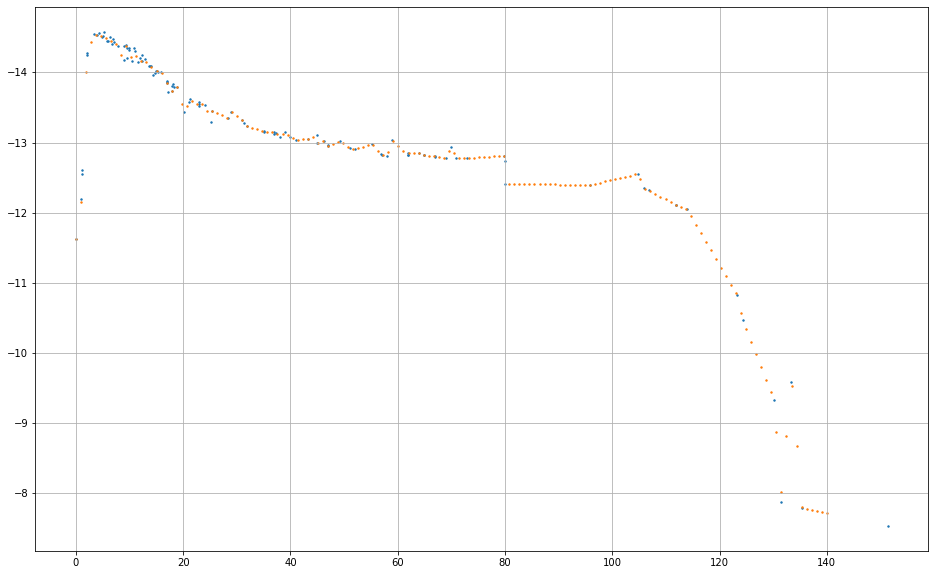

no. of data points is 82
the claimed type is Ia


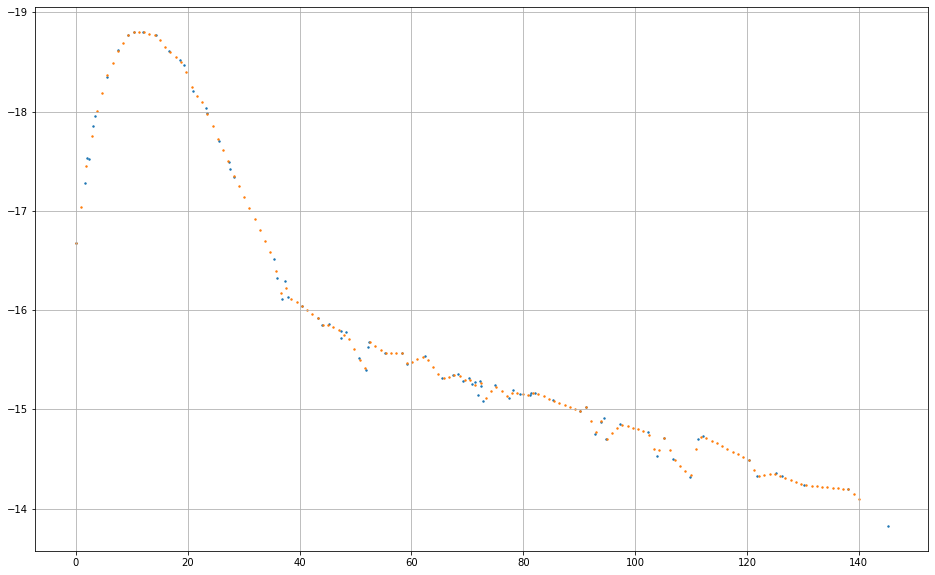

no. of data points is 248
the claimed type is Ia


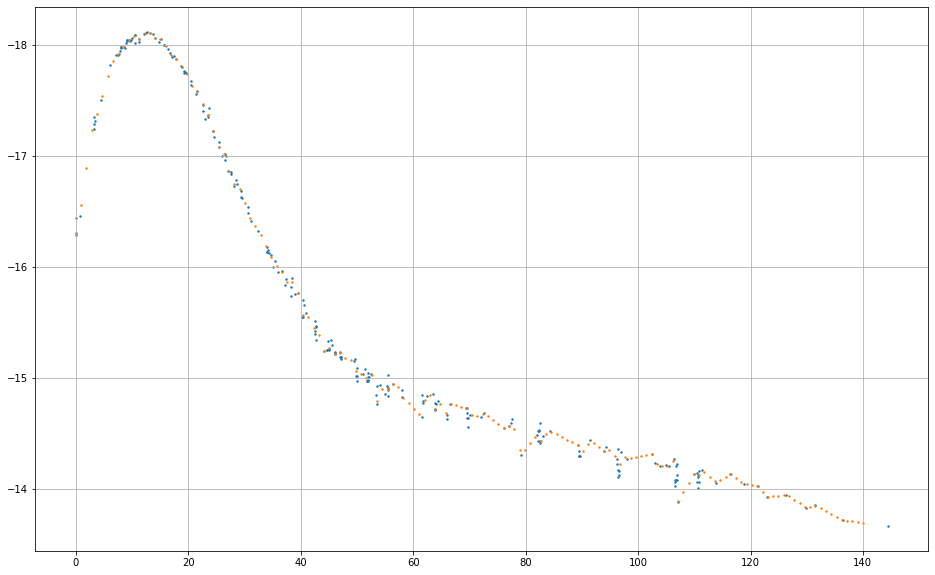

no. of data points is 69
the claimed type is II


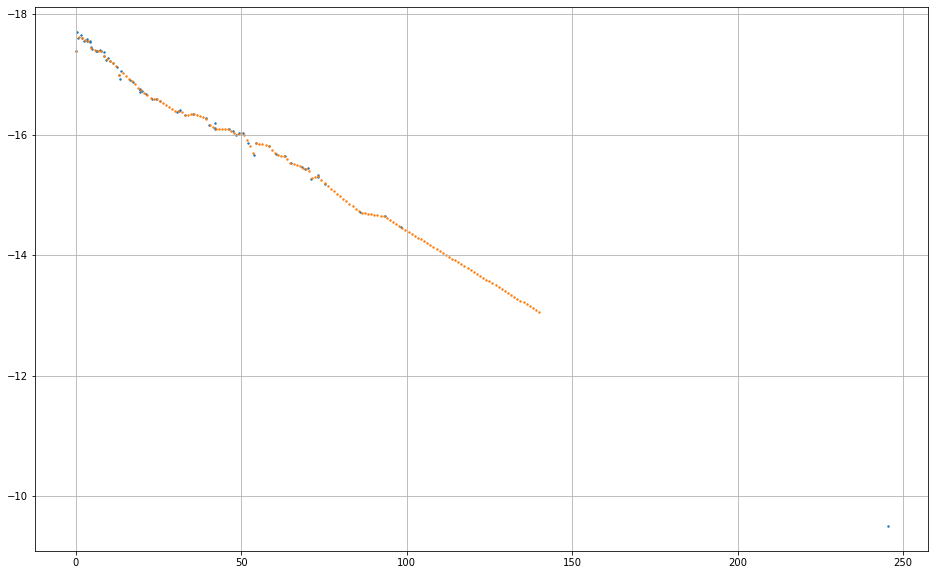

no. of data points is 89
the claimed type is Ia


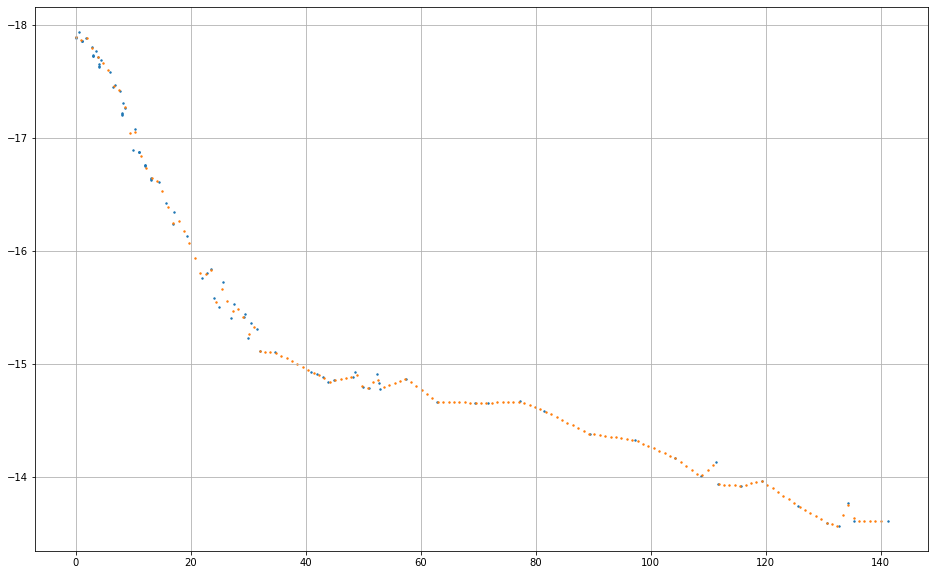

no. of data points is 92
the claimed type is Ia


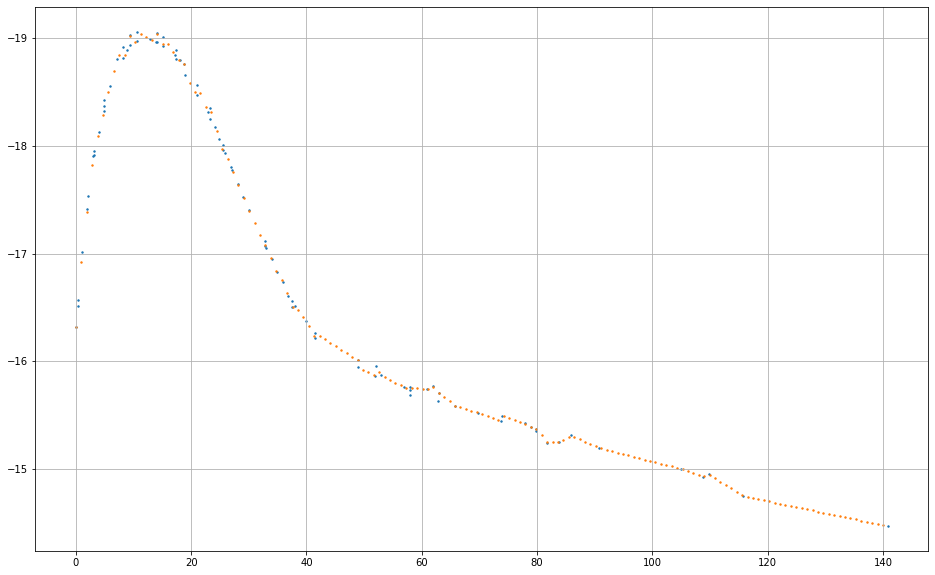

no. of data points is 357
the claimed type is Ia


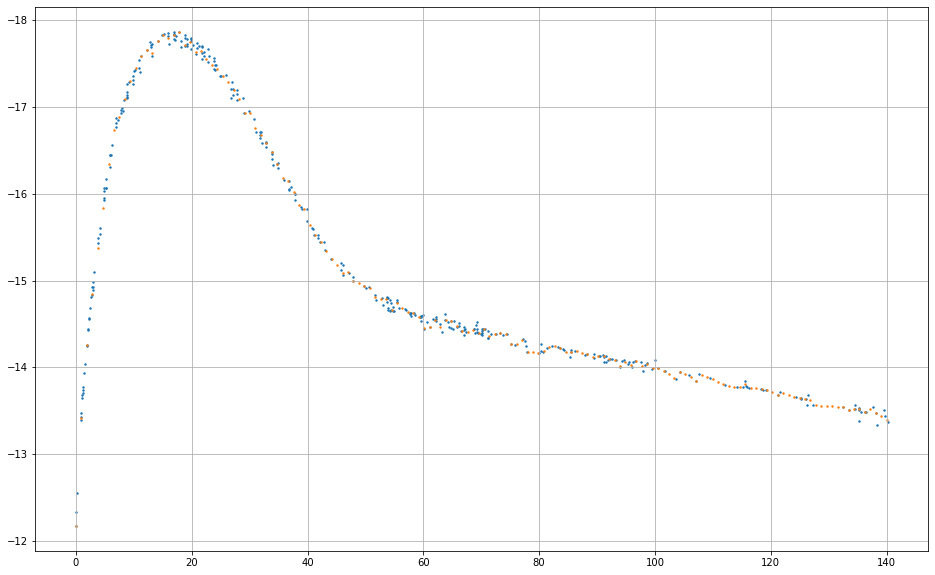

no. of data points is 237
the claimed type is II P


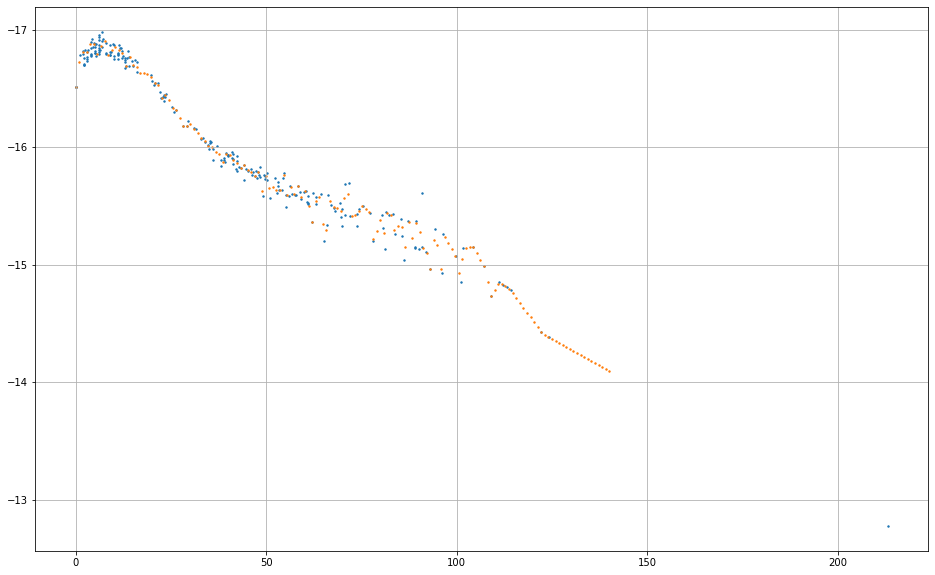

no. of data points is 144
the claimed type is Ia


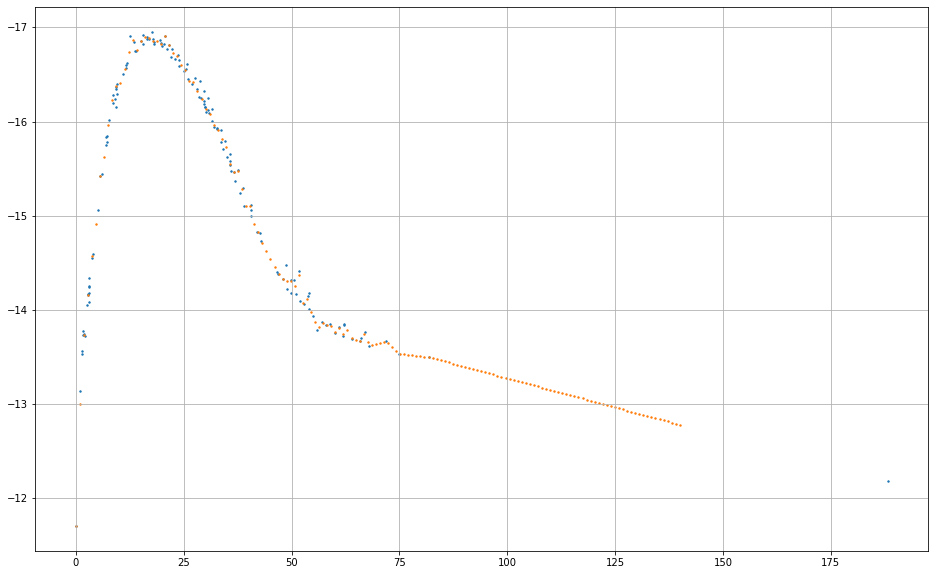

no. of data points is 250
the claimed type is Ia


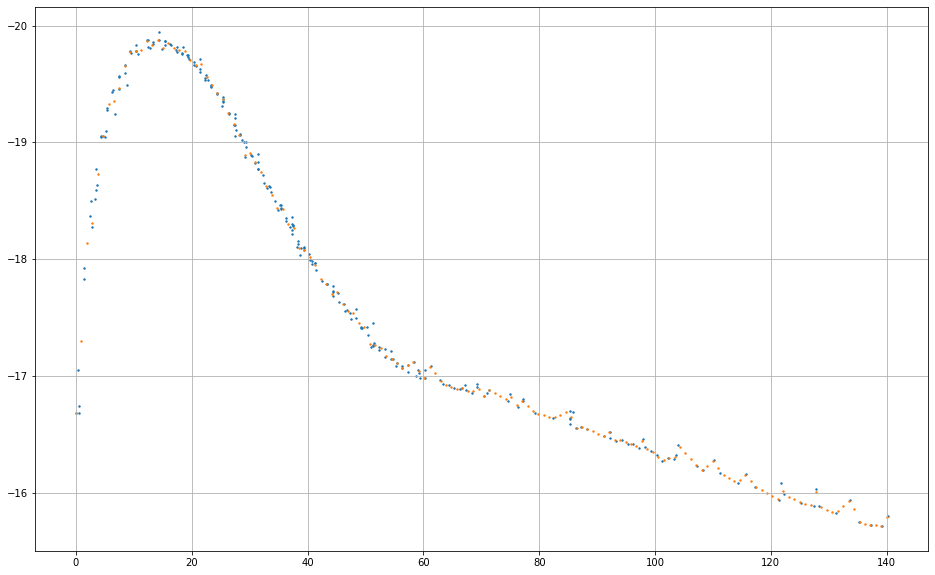

no. of data points is 97
the claimed type is Ia


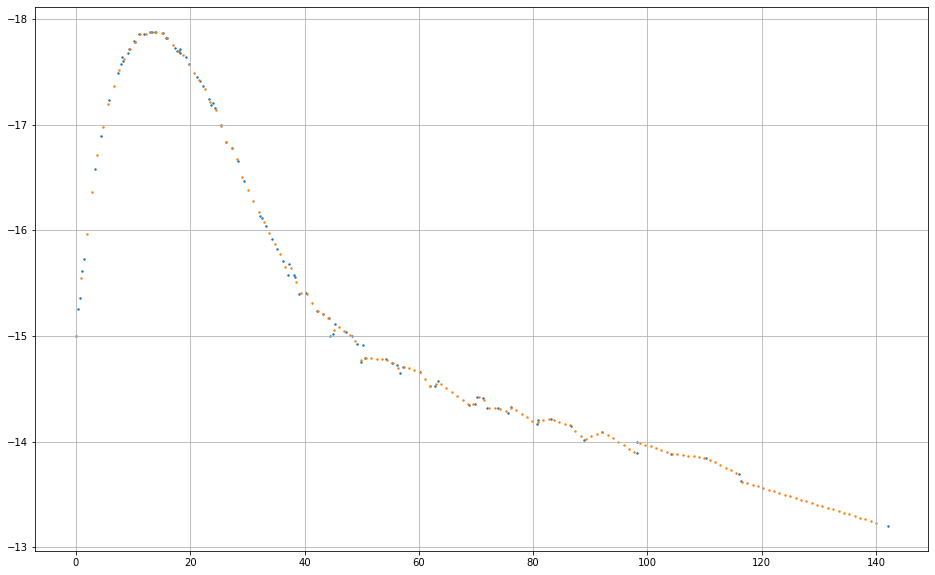

no. of data points is 88
the claimed type is Ia


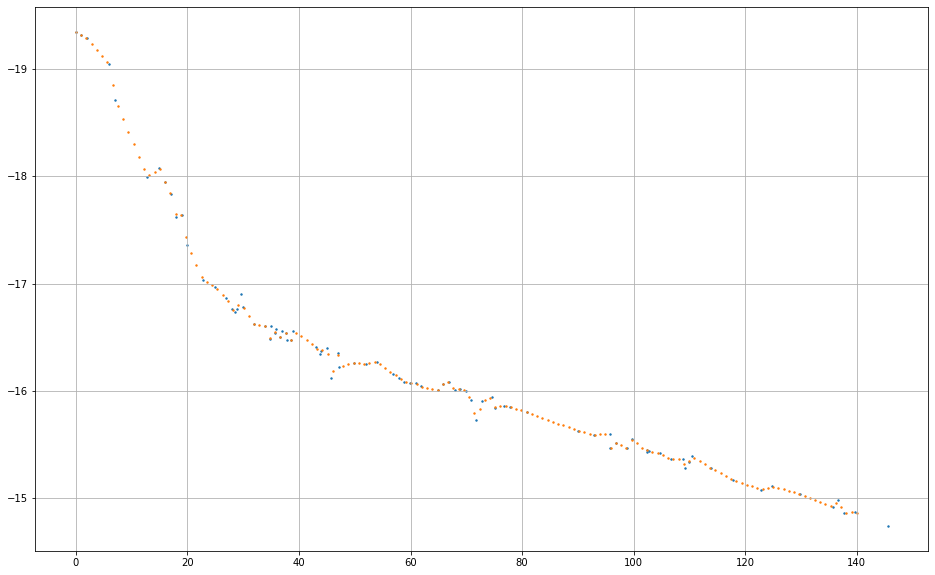

no. of data points is 131
the claimed type is II P


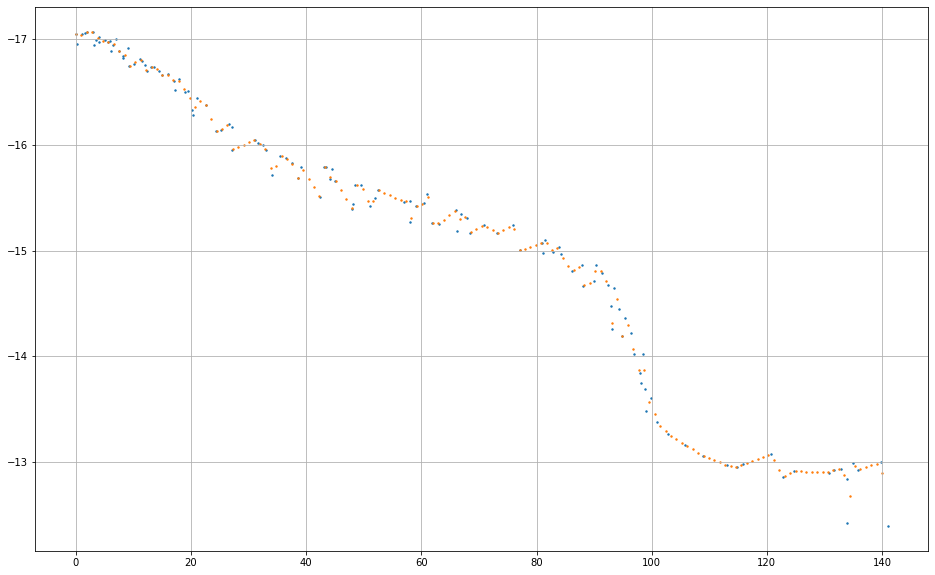

no. of data points is 241
the claimed type is II


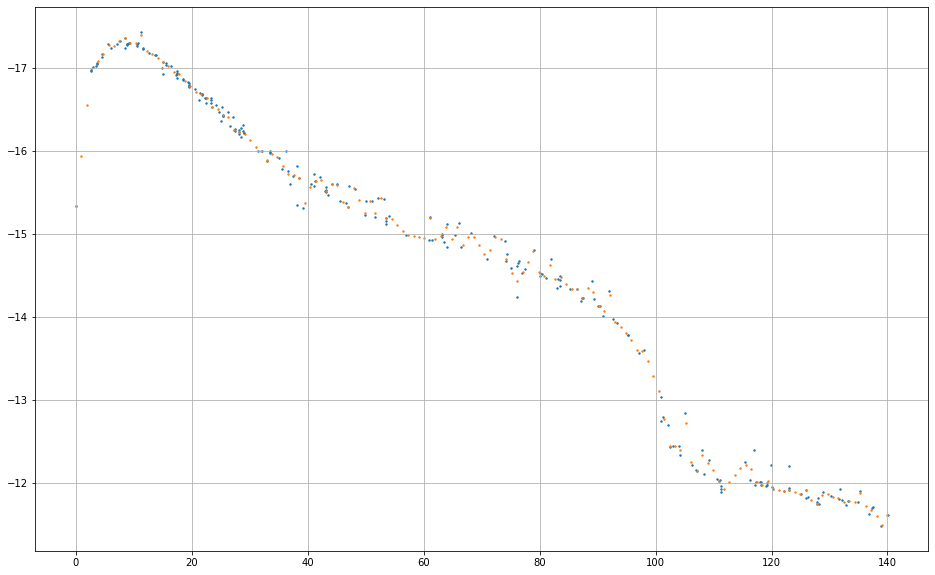

no. of data points is 69
the claimed type is II P


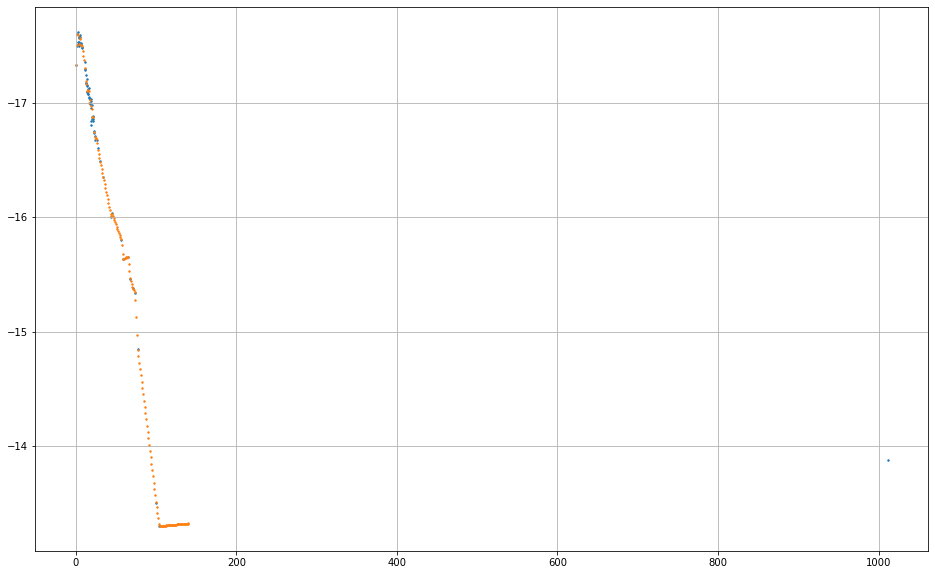

no. of data points is 128
the claimed type is II P


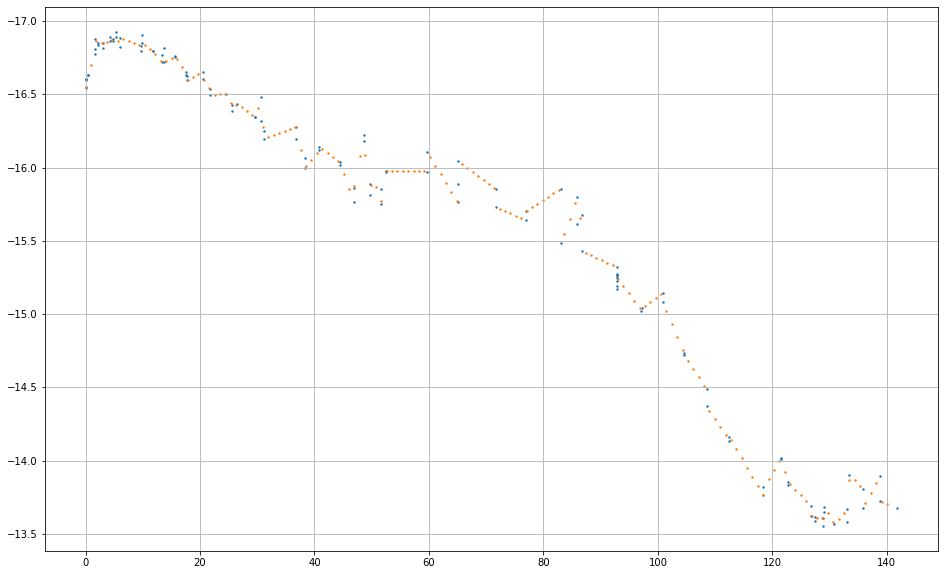

no. of data points is 91
the claimed type is II


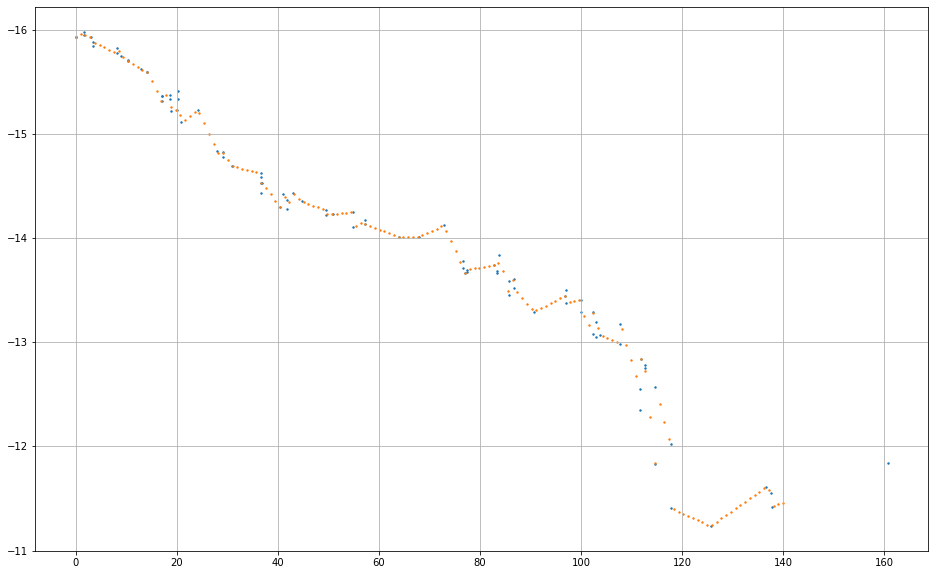

no. of data points is 110
the claimed type is Ia


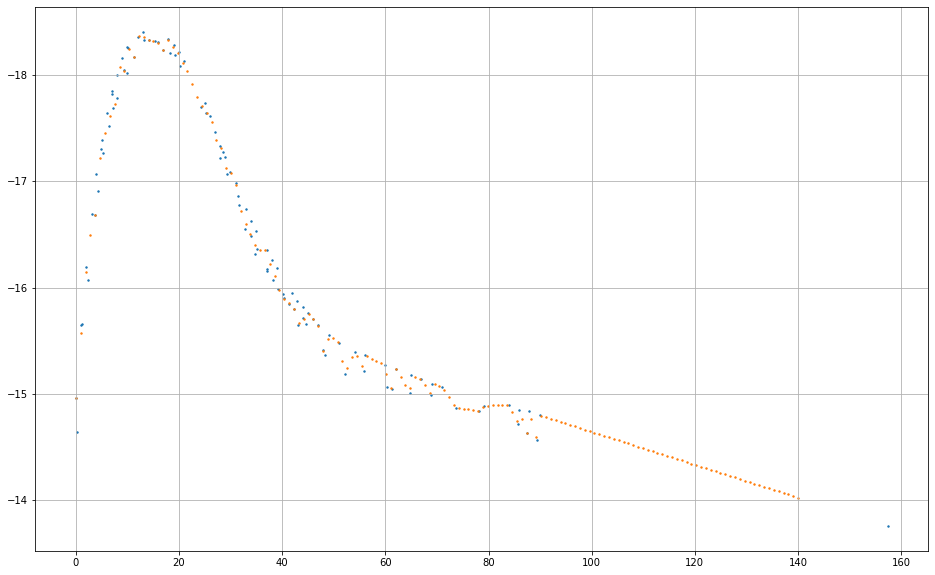

no. of data points is 85
the claimed type is Ia


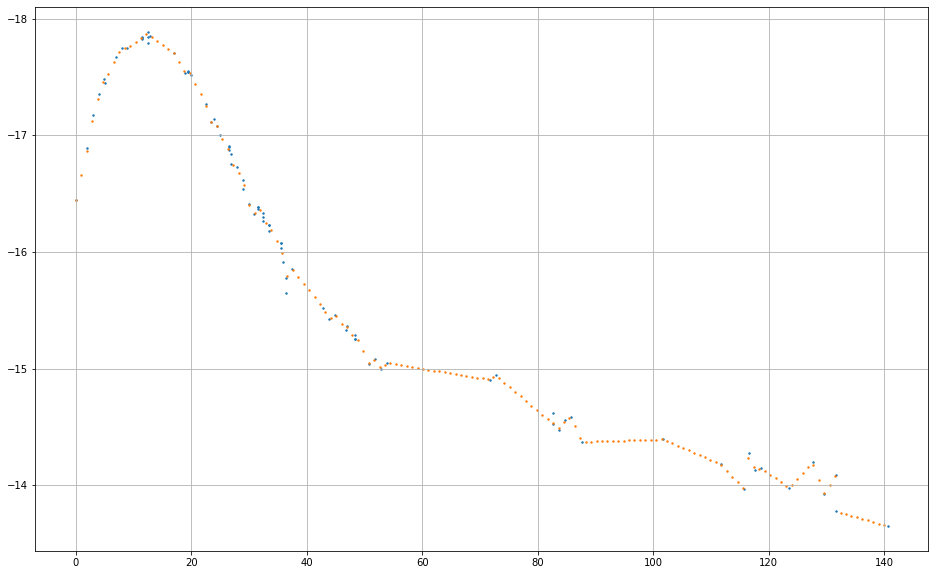

no. of data points is 161
the claimed type is II P


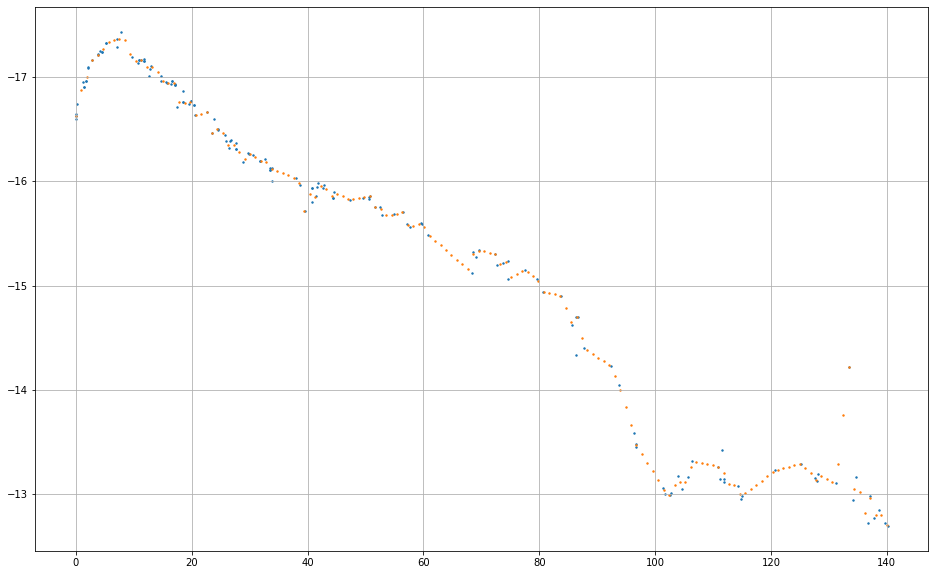

no. of data points is 104
the claimed type is II P


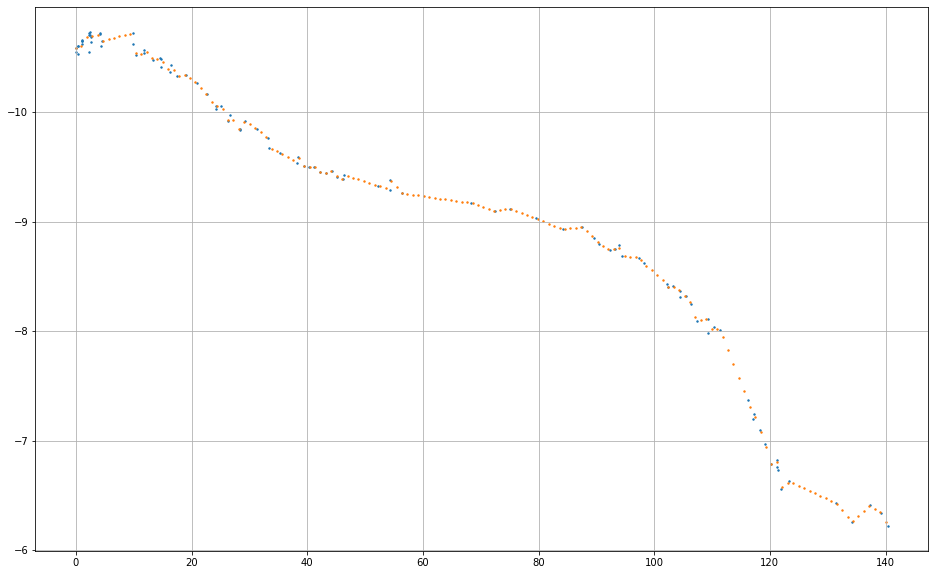

no. of data points is 80
the claimed type is Ia


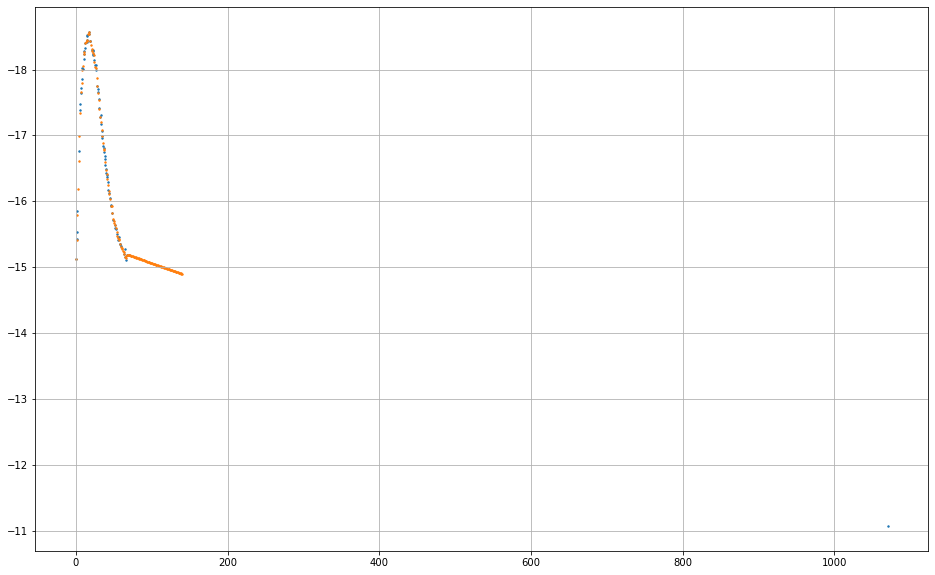

no. of data points is 65
the claimed type is Ia


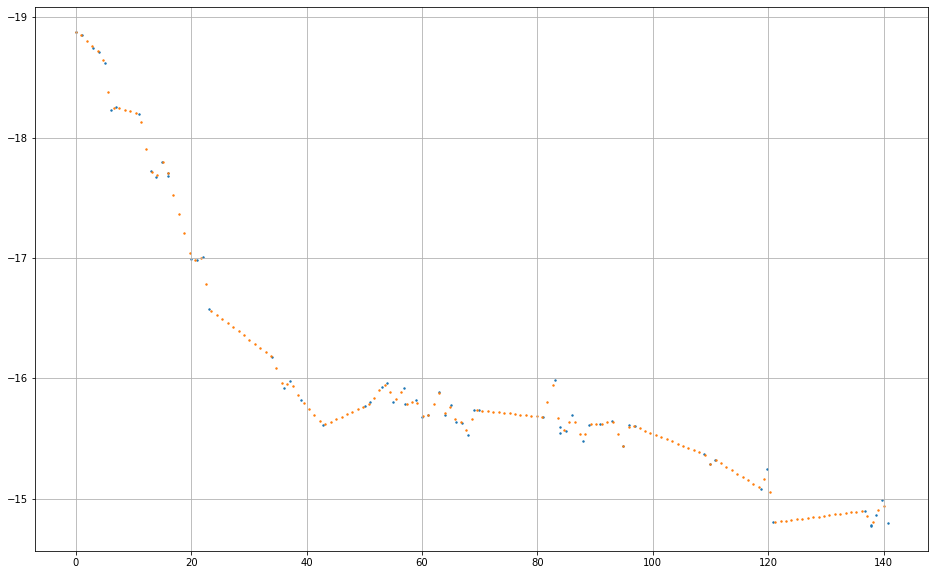

(40, 150, 1)
[[[-17.49868387]
  [-17.48928789]
  [-17.42098588]
  ...
  [-17.12026083]
  [-17.12501612]
  [-17.1297714 ]]

 [[-18.53444407]
  [-18.53520797]
  [-18.53597187]
  ...
  [-14.16444407]
  [-14.16444407]
  [-14.16444407]]

 [[-18.31534539]
  [-18.25318   ]
  [-18.286265  ]
  ...
  [-13.82942966]
  [-13.81853736]
  [-13.80764506]]

 ...

 [[-10.58532579]
  [-10.60421101]
  [-10.69009648]
  ...
  [ -6.37969463]
  [ -6.34630792]
  [ -6.25675912]]

 [[-15.12226632]
  [-15.40979537]
  [-15.78601295]
  ...
  [-14.90584057]
  [-14.90197795]
  [-14.89811533]]

 [[-18.87998802]
  [-18.85555849]
  [-18.80804016]
  ...
  [-14.80406856]
  [-14.90618028]
  [-14.93889328]]]


In [182]:
data = []
lightcurve_length_max = 0
lightcurve_num = 0
lightcurve_length = []
lightcurve_succ = []
lightcurve_days = 140


# To obtain individual lightcurve length (timesteps length) and the maximum lightcurve length
for i in range(len(filename)):
    
    if len(Time[i]) > 65: # Avoid lightcurve with too few data points
        if (Time[i][-1] - Time[i][0]) > lightcurve_days:
            for j in range(len(Time[i])):
                if (Time[i][j] - Time[i][0]) > lightcurve_days:
                    lightcurve_length.append(j)
                    lightcurve_length_max = max([j, lightcurve_length_max])
                    lightcurve_num += 1
                    lightcurve_succ.append(1)
                    break
        else:
            lightcurve_succ.append(0)
    else:
        lightcurve_succ.append(0)

print(lightcurve_length_max)
print(len(filename))
print(len(lightcurve_succ))
print(lightcurve_succ)
print(len(lightcurve_length))
print(lightcurve_length)

j = 0

steps = 150

for i in range(len(filename)):
    
    if lightcurve_succ[i] == 1:
        t_temp = np.array(Time[i]) 
        t = t_temp[0:lightcurve_length[j]+1] - t_temp[0]
        print('no. of data points is', len(t))
        print('the claimed type is', Type[i])
        m = Magnitude_Abs[i][0:lightcurve_length[j]+1]
        f = interp1d(t, m)
        tnew = np.linspace(0, lightcurve_days, steps)
        mnew = f(tnew)
        
        fig = plt.figure(figsize=(16,10))
        plt.gca().invert_yaxis()
        plt.grid()
        plt.scatter(t, m, s=2)
        plt.scatter(tnew, mnew, s=2)
        plt.show()
        
        data.append(mnew)
        j += 1

data = np.array(data)
lightcurve = data.reshape(lightcurve_num, steps, 1) #no. of sample (batch size), timesteps in RNN, no. of features

print(lightcurve.shape)
print(lightcurve)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_90 (GRU)                 (None, 150, 150)          68850     
_________________________________________________________________
gru_91 (GRU)                 (None, 150, 50)           30300     
_________________________________________________________________
gru_92 (GRU)                 (None, 10)                1860      
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 150, 10)           0         
_________________________________________________________________
gru_93 (GRU)                 (None, 150, 50)           9300      
_________________________________________________________________
gru_94 (GRU)                 (None, 150, 150)          90900     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 150, 1)          

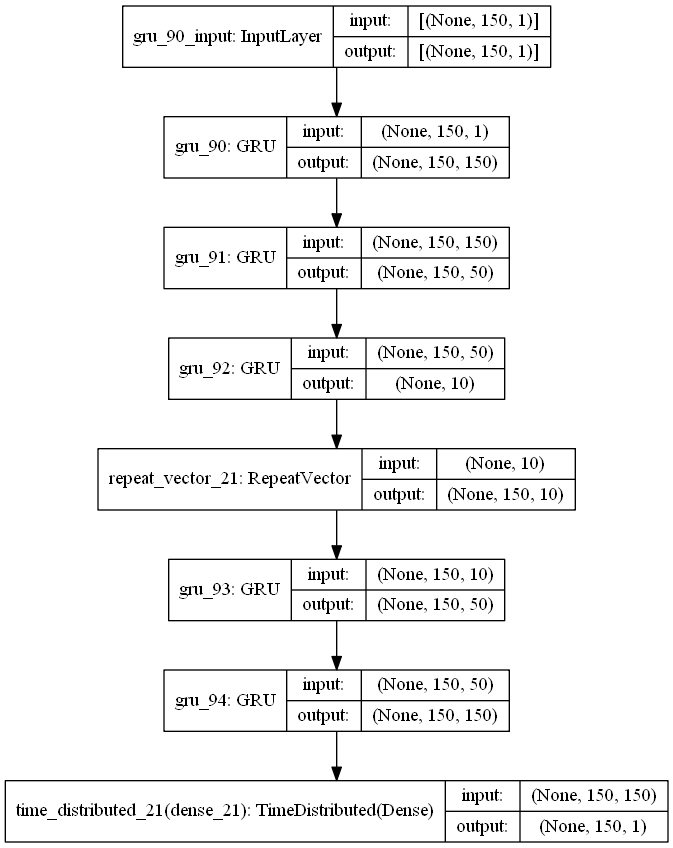

In [165]:
# define model
model = Sequential()
model.add(GRU(150, activation='tanh', input_shape=(steps,1), return_sequences=True))
model.add(GRU(50, activation='tanh', return_sequences=True))
model.add(GRU(10, activation='tanh', return_sequences=False))
model.add(RepeatVector(steps))
model.add(GRU(50, activation='tanh', return_sequences=True))
model.add(GRU(150, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, show_shapes=True)

In [166]:
# fit model
callbacks = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, restore_best_weights=True)
history = model.fit(lightcurve, lightcurve, validation_split = 0.25, epochs=1500, verbose=2)

Epoch 1/1500
1/1 - 6s - loss: 223.9345 - val_loss: 203.3926
Epoch 2/1500
1/1 - 0s - loss: 212.8512 - val_loss: 192.7285
Epoch 3/1500
1/1 - 0s - loss: 201.8614 - val_loss: 181.2030
Epoch 4/1500
1/1 - 0s - loss: 190.0042 - val_loss: 168.5389
Epoch 5/1500
1/1 - 0s - loss: 176.9679 - val_loss: 154.4739
Epoch 6/1500
1/1 - 0s - loss: 162.4680 - val_loss: 138.7919
Epoch 7/1500
1/1 - 0s - loss: 146.2708 - val_loss: 121.3166
Epoch 8/1500
1/1 - 0s - loss: 128.1788 - val_loss: 102.0378
Epoch 9/1500
1/1 - 0s - loss: 108.1575 - val_loss: 81.4803
Epoch 10/1500
1/1 - 0s - loss: 86.7147 - val_loss: 61.1020
Epoch 11/1500
1/1 - 0s - loss: 65.3188 - val_loss: 43.1324
Epoch 12/1500
1/1 - 0s - loss: 46.2609 - val_loss: 29.3353
Epoch 13/1500
1/1 - 0s - loss: 31.4071 - val_loss: 19.9859
Epoch 14/1500
1/1 - 0s - loss: 21.1133 - val_loss: 14.2320
Epoch 15/1500
1/1 - 0s - loss: 14.5606 - val_loss: 10.9639
Epoch 16/1500
1/1 - 0s - loss: 10.6359 - val_loss: 9.2724
Epoch 17/1500
1/1 - 0s - loss: 8.4118 - val_loss:

Epoch 144/1500
1/1 - 0s - loss: 4.1647 - val_loss: 5.9817
Epoch 145/1500
1/1 - 0s - loss: 4.1548 - val_loss: 5.9708
Epoch 146/1500
1/1 - 0s - loss: 4.1449 - val_loss: 5.9603
Epoch 147/1500
1/1 - 0s - loss: 4.1351 - val_loss: 5.9499
Epoch 148/1500
1/1 - 0s - loss: 4.1251 - val_loss: 5.9396
Epoch 149/1500
1/1 - 0s - loss: 4.1150 - val_loss: 5.9290
Epoch 150/1500
1/1 - 0s - loss: 4.1047 - val_loss: 5.9182
Epoch 151/1500
1/1 - 0s - loss: 4.0941 - val_loss: 5.9073
Epoch 152/1500
1/1 - 0s - loss: 4.0835 - val_loss: 5.8964
Epoch 153/1500
1/1 - 0s - loss: 4.0727 - val_loss: 5.8857
Epoch 154/1500
1/1 - 0s - loss: 4.0618 - val_loss: 5.8750
Epoch 155/1500
1/1 - 0s - loss: 4.0509 - val_loss: 5.8640
Epoch 156/1500
1/1 - 0s - loss: 4.0397 - val_loss: 5.8526
Epoch 157/1500
1/1 - 0s - loss: 4.0281 - val_loss: 5.8407
Epoch 158/1500
1/1 - 0s - loss: 4.0159 - val_loss: 5.8282
Epoch 159/1500
1/1 - 0s - loss: 4.0030 - val_loss: 5.8156
Epoch 160/1500
1/1 - 0s - loss: 3.9897 - val_loss: 5.8034
Epoch 161/1500

1/1 - 0s - loss: 2.9453 - val_loss: 4.7414
Epoch 286/1500
1/1 - 0s - loss: 2.9417 - val_loss: 4.7370
Epoch 287/1500
1/1 - 0s - loss: 2.9381 - val_loss: 4.7337
Epoch 288/1500
1/1 - 0s - loss: 2.9345 - val_loss: 4.7300
Epoch 289/1500
1/1 - 0s - loss: 2.9311 - val_loss: 4.7261
Epoch 290/1500
1/1 - 0s - loss: 2.9276 - val_loss: 4.7231
Epoch 291/1500
1/1 - 0s - loss: 2.9242 - val_loss: 4.7189
Epoch 292/1500
1/1 - 0s - loss: 2.9208 - val_loss: 4.7159
Epoch 293/1500
1/1 - 0s - loss: 2.9175 - val_loss: 4.7122
Epoch 294/1500
1/1 - 0s - loss: 2.9142 - val_loss: 4.7090
Epoch 295/1500
1/1 - 0s - loss: 2.9109 - val_loss: 4.7055
Epoch 296/1500
1/1 - 0s - loss: 2.9077 - val_loss: 4.7025
Epoch 297/1500
1/1 - 0s - loss: 2.9045 - val_loss: 4.6989
Epoch 298/1500
1/1 - 0s - loss: 2.9014 - val_loss: 4.6959
Epoch 299/1500
1/1 - 0s - loss: 2.8983 - val_loss: 4.6924
Epoch 300/1500
1/1 - 0s - loss: 2.8953 - val_loss: 4.6896
Epoch 301/1500
1/1 - 0s - loss: 2.8922 - val_loss: 4.6860
Epoch 302/1500
1/1 - 0s - los

Epoch 427/1500
1/1 - 0s - loss: 2.7096 - val_loss: 4.4836
Epoch 428/1500
1/1 - 0s - loss: 2.7091 - val_loss: 4.5003
Epoch 429/1500
1/1 - 0s - loss: 2.7084 - val_loss: 4.4866
Epoch 430/1500
1/1 - 0s - loss: 2.7077 - val_loss: 4.4898
Epoch 431/1500
1/1 - 0s - loss: 2.7071 - val_loss: 4.4948
Epoch 432/1500
1/1 - 0s - loss: 2.7066 - val_loss: 4.4817
Epoch 433/1500
1/1 - 0s - loss: 2.7061 - val_loss: 4.4953
Epoch 434/1500
1/1 - 0s - loss: 2.7055 - val_loss: 4.4839
Epoch 435/1500
1/1 - 0s - loss: 2.7048 - val_loss: 4.4863
Epoch 436/1500
1/1 - 0s - loss: 2.7042 - val_loss: 4.4908
Epoch 437/1500
1/1 - 0s - loss: 2.7037 - val_loss: 4.4792
Epoch 438/1500
1/1 - 0s - loss: 2.7032 - val_loss: 4.4906
Epoch 439/1500
1/1 - 0s - loss: 2.7026 - val_loss: 4.4817
Epoch 440/1500
1/1 - 0s - loss: 2.7020 - val_loss: 4.4823
Epoch 441/1500
1/1 - 0s - loss: 2.7015 - val_loss: 4.4872
Epoch 442/1500
1/1 - 0s - loss: 2.7010 - val_loss: 4.4771
Epoch 443/1500
1/1 - 0s - loss: 2.7005 - val_loss: 4.4858
Epoch 444/1500

1/1 - 0s - loss: 2.6555 - val_loss: 4.4336
Epoch 569/1500
1/1 - 0s - loss: 2.6553 - val_loss: 4.4222
Epoch 570/1500
1/1 - 0s - loss: 2.6550 - val_loss: 4.4333
Epoch 571/1500
1/1 - 0s - loss: 2.6548 - val_loss: 4.4215
Epoch 572/1500
1/1 - 0s - loss: 2.6545 - val_loss: 4.4327
Epoch 573/1500
1/1 - 0s - loss: 2.6543 - val_loss: 4.4209
Epoch 574/1500
1/1 - 0s - loss: 2.6540 - val_loss: 4.4318
Epoch 575/1500
1/1 - 0s - loss: 2.6538 - val_loss: 4.4208
Epoch 576/1500
1/1 - 0s - loss: 2.6535 - val_loss: 4.4305
Epoch 577/1500
1/1 - 0s - loss: 2.6533 - val_loss: 4.4210
Epoch 578/1500
1/1 - 0s - loss: 2.6530 - val_loss: 4.4287
Epoch 579/1500
1/1 - 0s - loss: 2.6528 - val_loss: 4.4218
Epoch 580/1500
1/1 - 0s - loss: 2.6525 - val_loss: 4.4266
Epoch 581/1500
1/1 - 0s - loss: 2.6522 - val_loss: 4.4224
Epoch 582/1500
1/1 - 0s - loss: 2.6520 - val_loss: 4.4248
Epoch 583/1500
1/1 - 0s - loss: 2.6518 - val_loss: 4.4230
Epoch 584/1500
1/1 - 0s - loss: 2.6515 - val_loss: 4.4228
Epoch 585/1500
1/1 - 0s - los

Epoch 710/1500
1/1 - 0s - loss: 0.6655 - val_loss: 1.0305
Epoch 711/1500
1/1 - 0s - loss: 0.6517 - val_loss: 1.0164
Epoch 712/1500
1/1 - 0s - loss: 0.6443 - val_loss: 1.0170
Epoch 713/1500
1/1 - 0s - loss: 0.6433 - val_loss: 0.9901
Epoch 714/1500
1/1 - 0s - loss: 0.6414 - val_loss: 0.9927
Epoch 715/1500
1/1 - 0s - loss: 0.6338 - val_loss: 0.9620
Epoch 716/1500
1/1 - 0s - loss: 0.6231 - val_loss: 0.9525
Epoch 717/1500
1/1 - 0s - loss: 0.6143 - val_loss: 0.9426
Epoch 718/1500
1/1 - 0s - loss: 0.6096 - val_loss: 0.9265
Epoch 719/1500
1/1 - 0s - loss: 0.6074 - val_loss: 0.9280
Epoch 720/1500
1/1 - 0s - loss: 0.6050 - val_loss: 0.9068
Epoch 721/1500
1/1 - 0s - loss: 0.6010 - val_loss: 0.9044
Epoch 722/1500
1/1 - 0s - loss: 0.5946 - val_loss: 0.8833
Epoch 723/1500
1/1 - 0s - loss: 0.5868 - val_loss: 0.8746
Epoch 724/1500
1/1 - 0s - loss: 0.5796 - val_loss: 0.8624
Epoch 725/1500
1/1 - 0s - loss: 0.5743 - val_loss: 0.8519
Epoch 726/1500
1/1 - 0s - loss: 0.5708 - val_loss: 0.8473
Epoch 727/1500

1/1 - 0s - loss: 0.3611 - val_loss: 0.4334
Epoch 852/1500
1/1 - 0s - loss: 0.3607 - val_loss: 0.4341
Epoch 853/1500
1/1 - 0s - loss: 0.3610 - val_loss: 0.4334
Epoch 854/1500
1/1 - 0s - loss: 0.3618 - val_loss: 0.4354
Epoch 855/1500
1/1 - 0s - loss: 0.3626 - val_loss: 0.4340
Epoch 856/1500
1/1 - 0s - loss: 0.3635 - val_loss: 0.4364
Epoch 857/1500
1/1 - 0s - loss: 0.3643 - val_loss: 0.4341
Epoch 858/1500
1/1 - 0s - loss: 0.3647 - val_loss: 0.4361
Epoch 859/1500
1/1 - 0s - loss: 0.3648 - val_loss: 0.4329
Epoch 860/1500
1/1 - 0s - loss: 0.3643 - val_loss: 0.4340
Epoch 861/1500
1/1 - 0s - loss: 0.3633 - val_loss: 0.4300
Epoch 862/1500
1/1 - 0s - loss: 0.3616 - val_loss: 0.4299
Epoch 863/1500
1/1 - 0s - loss: 0.3597 - val_loss: 0.4262
Epoch 864/1500
1/1 - 0s - loss: 0.3576 - val_loss: 0.4258
Epoch 865/1500
1/1 - 0s - loss: 0.3559 - val_loss: 0.4235
Epoch 866/1500
1/1 - 0s - loss: 0.3546 - val_loss: 0.4232
Epoch 867/1500
1/1 - 0s - loss: 0.3535 - val_loss: 0.4218
Epoch 868/1500
1/1 - 0s - los

Epoch 993/1500
1/1 - 0s - loss: 0.3375 - val_loss: 0.3736
Epoch 994/1500
1/1 - 0s - loss: 0.3112 - val_loss: 0.3689
Epoch 995/1500
1/1 - 0s - loss: 0.3043 - val_loss: 0.3827
Epoch 996/1500
1/1 - 0s - loss: 0.3183 - val_loss: 0.3950
Epoch 997/1500
1/1 - 0s - loss: 0.3360 - val_loss: 0.4086
Epoch 998/1500
1/1 - 0s - loss: 0.3416 - val_loss: 0.3827
Epoch 999/1500
1/1 - 0s - loss: 0.3241 - val_loss: 0.3720
Epoch 1000/1500
1/1 - 0s - loss: 0.3054 - val_loss: 0.3771
Epoch 1001/1500
1/1 - 0s - loss: 0.3088 - val_loss: 0.3866
Epoch 1002/1500
1/1 - 0s - loss: 0.3260 - val_loss: 0.4001
Epoch 1003/1500
1/1 - 0s - loss: 0.3348 - val_loss: 0.3840
Epoch 1004/1500
1/1 - 0s - loss: 0.3236 - val_loss: 0.3743
Epoch 1005/1500
1/1 - 0s - loss: 0.3069 - val_loss: 0.3702
Epoch 1006/1500
1/1 - 0s - loss: 0.3041 - val_loss: 0.3743
Epoch 1007/1500
1/1 - 0s - loss: 0.3140 - val_loss: 0.3838
Epoch 1008/1500
1/1 - 0s - loss: 0.3176 - val_loss: 0.3719
Epoch 1009/1500
1/1 - 0s - loss: 0.3094 - val_loss: 0.3672
Epoc

Epoch 1132/1500
1/1 - 0s - loss: 0.2770 - val_loss: 0.3552
Epoch 1133/1500
1/1 - 0s - loss: 0.2767 - val_loss: 0.3551
Epoch 1134/1500
1/1 - 0s - loss: 0.2765 - val_loss: 0.3548
Epoch 1135/1500
1/1 - 0s - loss: 0.2764 - val_loss: 0.3553
Epoch 1136/1500
1/1 - 0s - loss: 0.2763 - val_loss: 0.3547
Epoch 1137/1500
1/1 - 0s - loss: 0.2761 - val_loss: 0.3550
Epoch 1138/1500
1/1 - 0s - loss: 0.2758 - val_loss: 0.3546
Epoch 1139/1500
1/1 - 0s - loss: 0.2755 - val_loss: 0.3545
Epoch 1140/1500
1/1 - 0s - loss: 0.2754 - val_loss: 0.3547
Epoch 1141/1500
1/1 - 0s - loss: 0.2752 - val_loss: 0.3543
Epoch 1142/1500
1/1 - 0s - loss: 0.2751 - val_loss: 0.3547
Epoch 1143/1500
1/1 - 0s - loss: 0.2750 - val_loss: 0.3541
Epoch 1144/1500
1/1 - 0s - loss: 0.2748 - val_loss: 0.3546
Epoch 1145/1500
1/1 - 0s - loss: 0.2746 - val_loss: 0.3539
Epoch 1146/1500
1/1 - 0s - loss: 0.2744 - val_loss: 0.3542
Epoch 1147/1500
1/1 - 0s - loss: 0.2741 - val_loss: 0.3537
Epoch 1148/1500
1/1 - 0s - loss: 0.2739 - val_loss: 0.35

Epoch 1271/1500
1/1 - 0s - loss: 0.2560 - val_loss: 0.3492
Epoch 1272/1500
1/1 - 0s - loss: 0.2558 - val_loss: 0.3491
Epoch 1273/1500
1/1 - 0s - loss: 0.2557 - val_loss: 0.3491
Epoch 1274/1500
1/1 - 0s - loss: 0.2555 - val_loss: 0.3491
Epoch 1275/1500
1/1 - 0s - loss: 0.2554 - val_loss: 0.3490
Epoch 1276/1500
1/1 - 0s - loss: 0.2553 - val_loss: 0.3490
Epoch 1277/1500
1/1 - 0s - loss: 0.2552 - val_loss: 0.3489
Epoch 1278/1500
1/1 - 0s - loss: 0.2550 - val_loss: 0.3490
Epoch 1279/1500
1/1 - 0s - loss: 0.2549 - val_loss: 0.3489
Epoch 1280/1500
1/1 - 0s - loss: 0.2548 - val_loss: 0.3490
Epoch 1281/1500
1/1 - 0s - loss: 0.2547 - val_loss: 0.3490
Epoch 1282/1500
1/1 - 0s - loss: 0.2547 - val_loss: 0.3491
Epoch 1283/1500
1/1 - 0s - loss: 0.2547 - val_loss: 0.3493
Epoch 1284/1500
1/1 - 0s - loss: 0.2550 - val_loss: 0.3501
Epoch 1285/1500
1/1 - 0s - loss: 0.2557 - val_loss: 0.3514
Epoch 1286/1500
1/1 - 0s - loss: 0.2574 - val_loss: 0.3546
Epoch 1287/1500
1/1 - 0s - loss: 0.2608 - val_loss: 0.36

Epoch 1410/1500
1/1 - 0s - loss: 0.2413 - val_loss: 0.3469
Epoch 1411/1500
1/1 - 0s - loss: 0.2451 - val_loss: 0.3520
Epoch 1412/1500
1/1 - 0s - loss: 0.2501 - val_loss: 0.3511
Epoch 1413/1500
1/1 - 0s - loss: 0.2501 - val_loss: 0.3489
Epoch 1414/1500
1/1 - 0s - loss: 0.2475 - val_loss: 0.3460
Epoch 1415/1500
1/1 - 0s - loss: 0.2425 - val_loss: 0.3443
Epoch 1416/1500
1/1 - 0s - loss: 0.2404 - val_loss: 0.3464
Epoch 1417/1500
1/1 - 0s - loss: 0.2428 - val_loss: 0.3477
Epoch 1418/1500
1/1 - 0s - loss: 0.2452 - val_loss: 0.3492
Epoch 1419/1500
1/1 - 0s - loss: 0.2462 - val_loss: 0.3487
Epoch 1420/1500
1/1 - 0s - loss: 0.2445 - val_loss: 0.3462
Epoch 1421/1500
1/1 - 0s - loss: 0.2416 - val_loss: 0.3451
Epoch 1422/1500
1/1 - 0s - loss: 0.2399 - val_loss: 0.3452
Epoch 1423/1500
1/1 - 0s - loss: 0.2400 - val_loss: 0.3465
Epoch 1424/1500
1/1 - 0s - loss: 0.2408 - val_loss: 0.3480
Epoch 1425/1500
1/1 - 0s - loss: 0.2425 - val_loss: 0.3491
Epoch 1426/1500
1/1 - 0s - loss: 0.2440 - val_loss: 0.34

(0.0, 1.0)

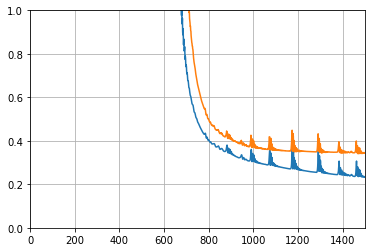

In [168]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.xlim(0, 1500)
plt.ylim(0, 1)

In [169]:
# demonstrate recreation
yhat = model.predict(lightcurve, verbose=2)
yhat1 = model.predict(yhat, verbose=2)
#print(yhat[0,:,0])

2/2 - 1s
2/2 - 0s


the claimed type is II P


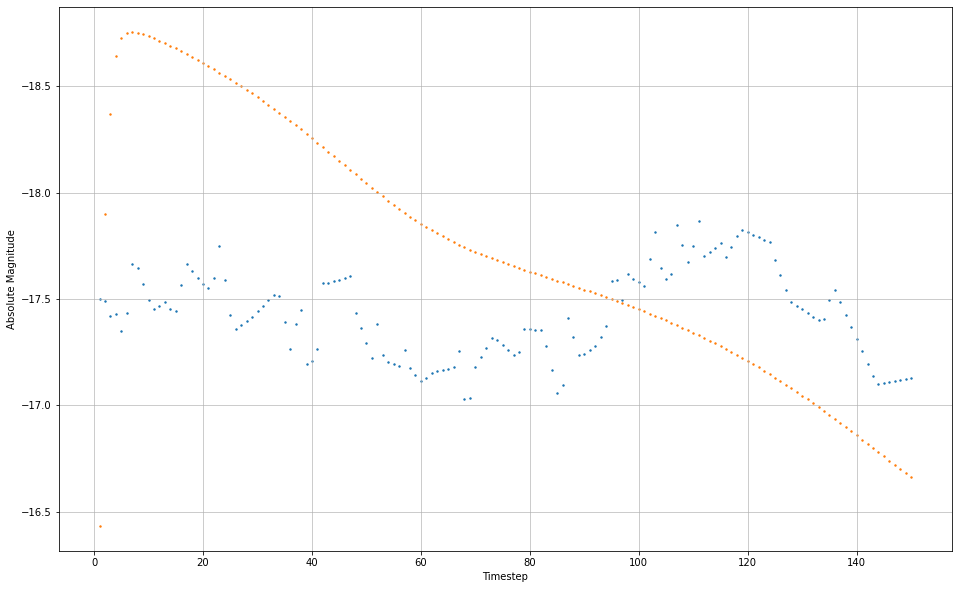

the claimed type is Ia


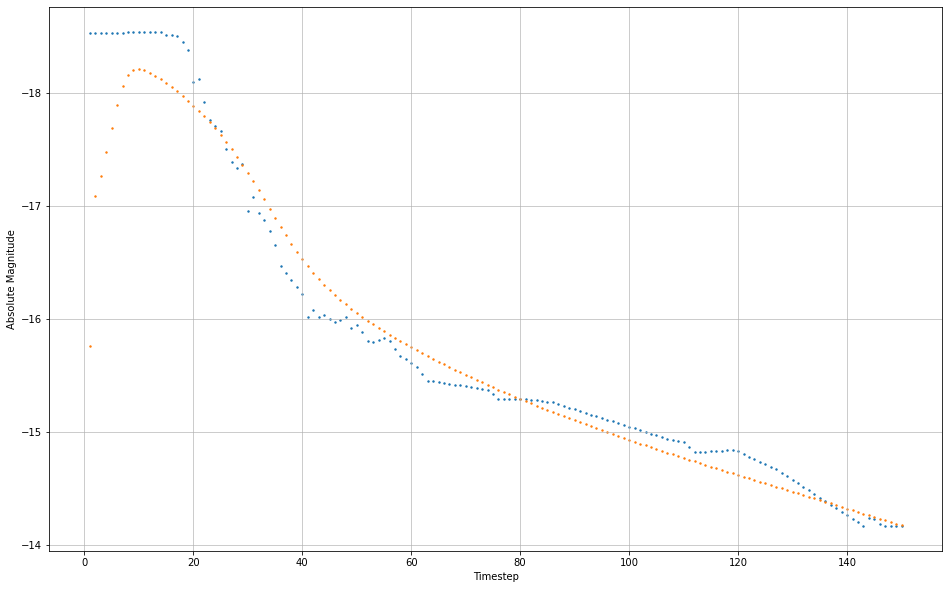

the claimed type is Ia


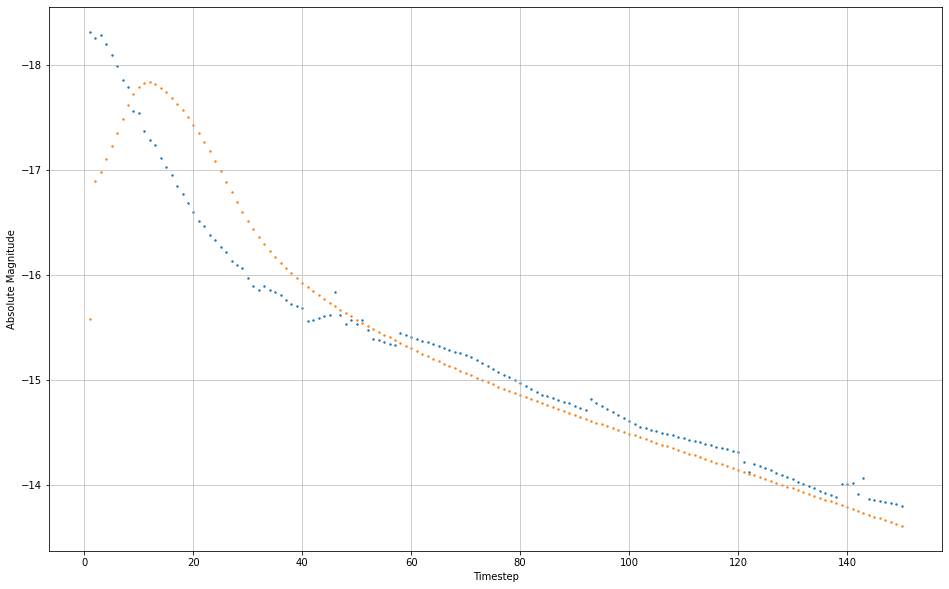

the claimed type is Ia


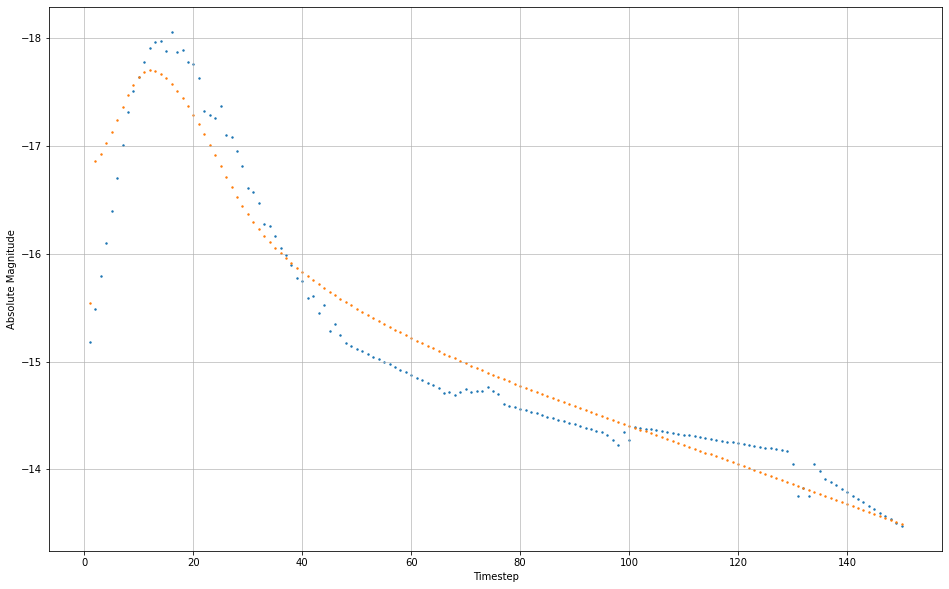

the claimed type is Ia


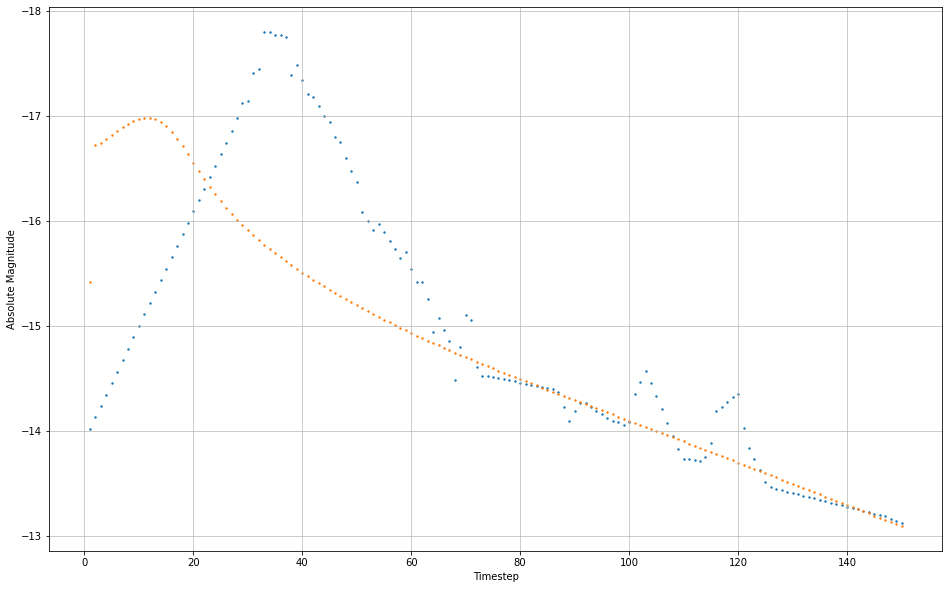

the claimed type is Ia


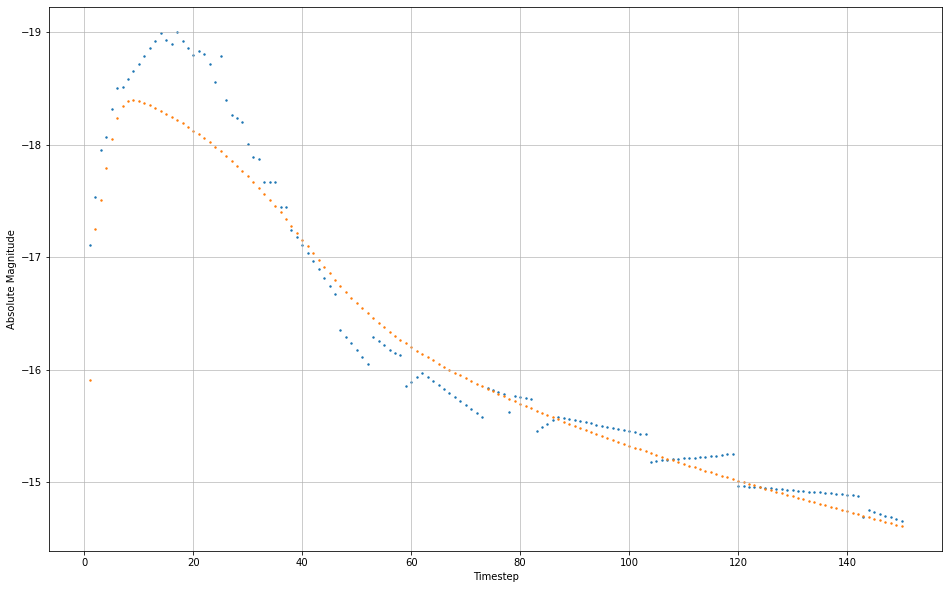

the claimed type is Ia


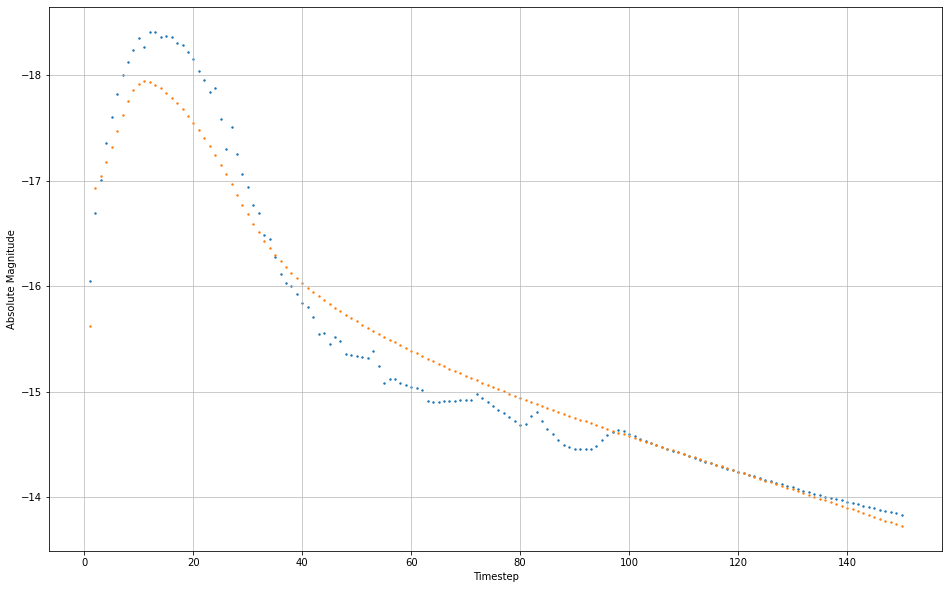

the claimed type is II P


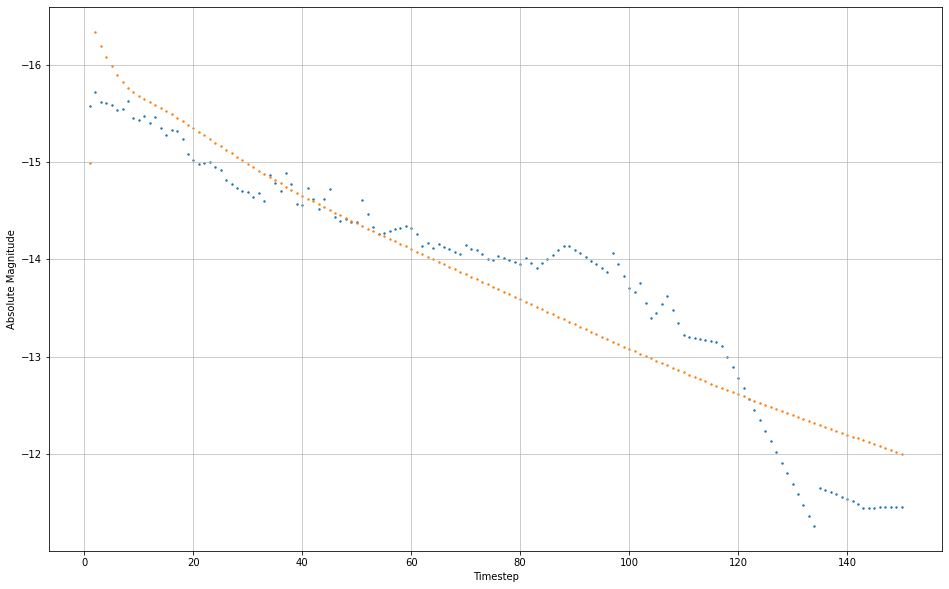

the claimed type is Ia Pec


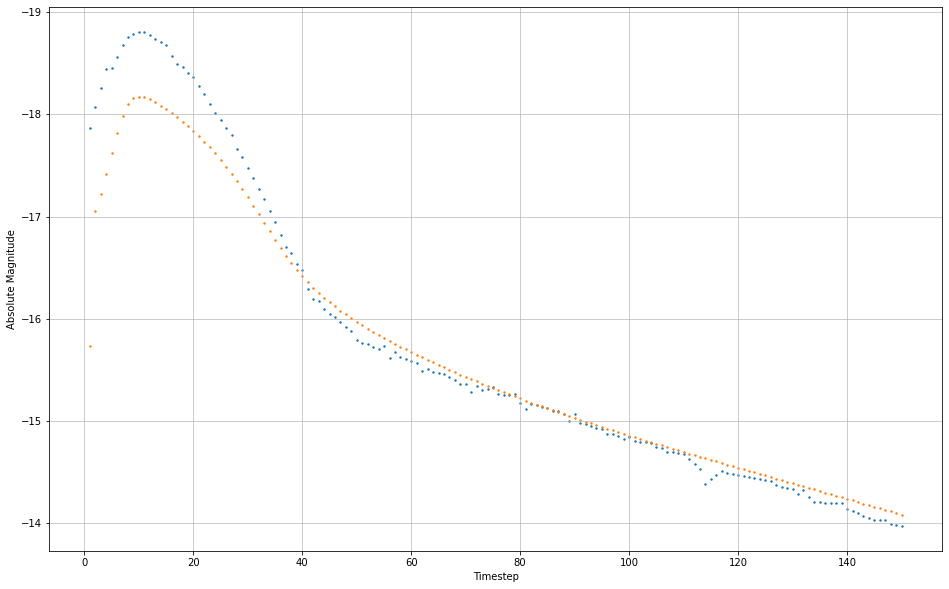

the claimed type is Ia


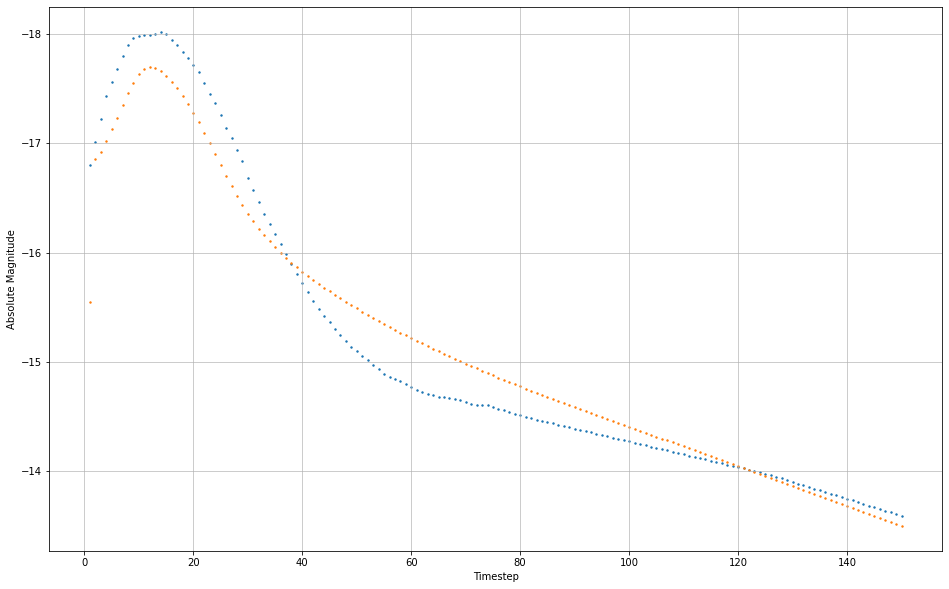

the claimed type is Ia


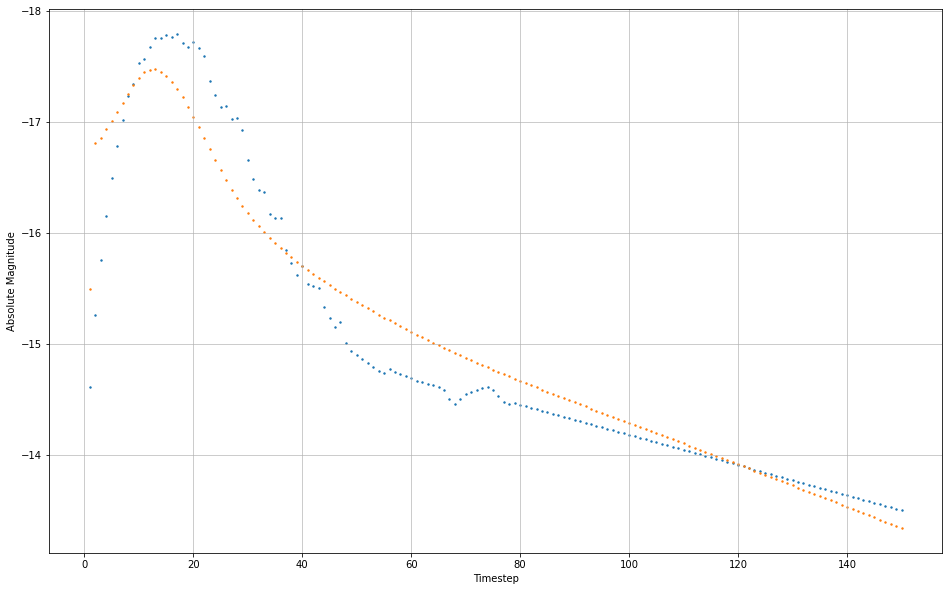

the claimed type is Ia


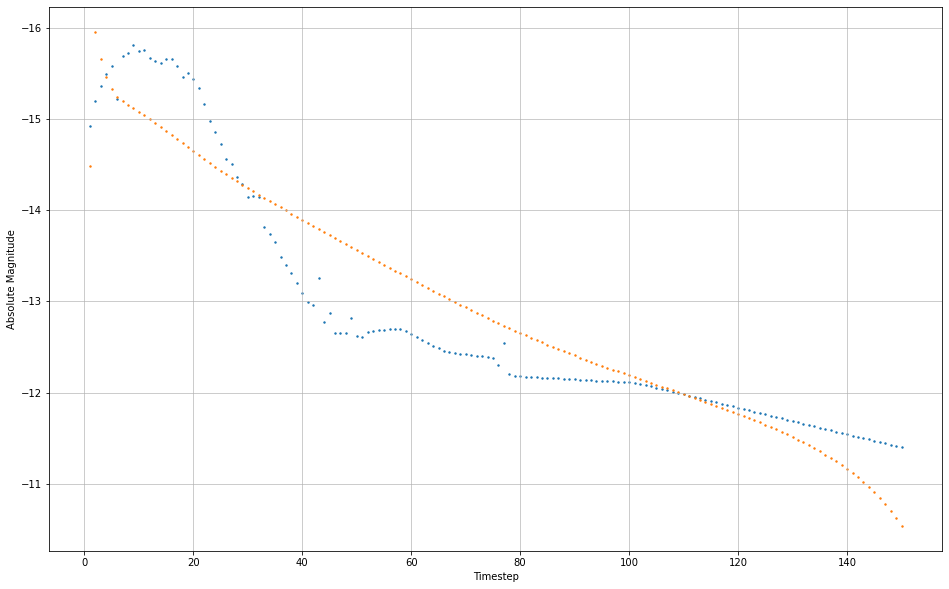

the claimed type is Ia


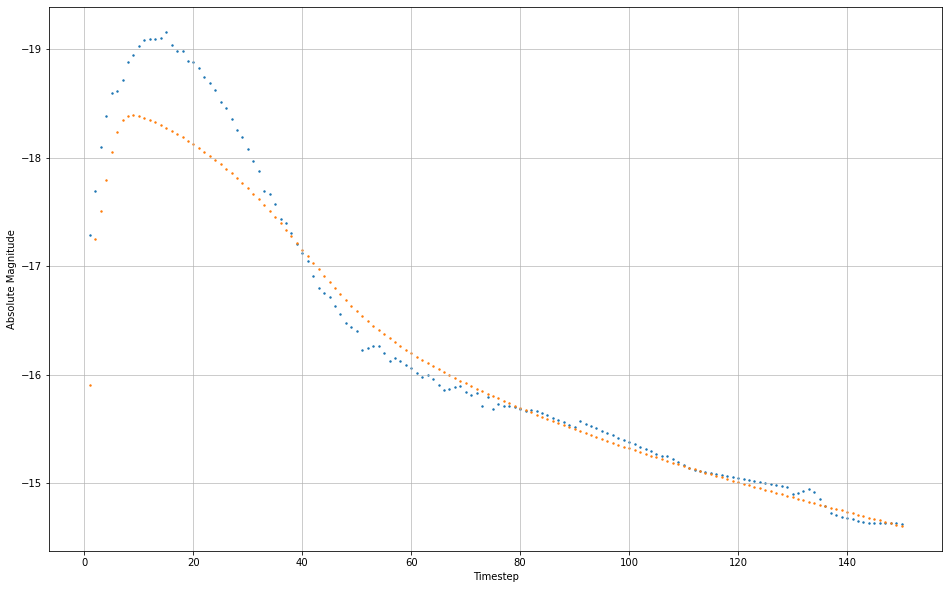

the claimed type is II P


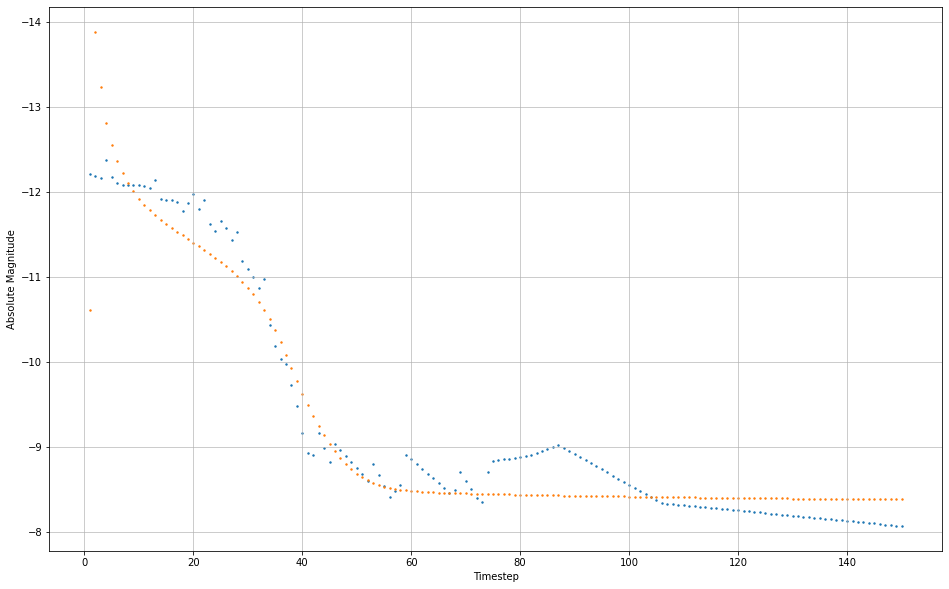

the claimed type is II P


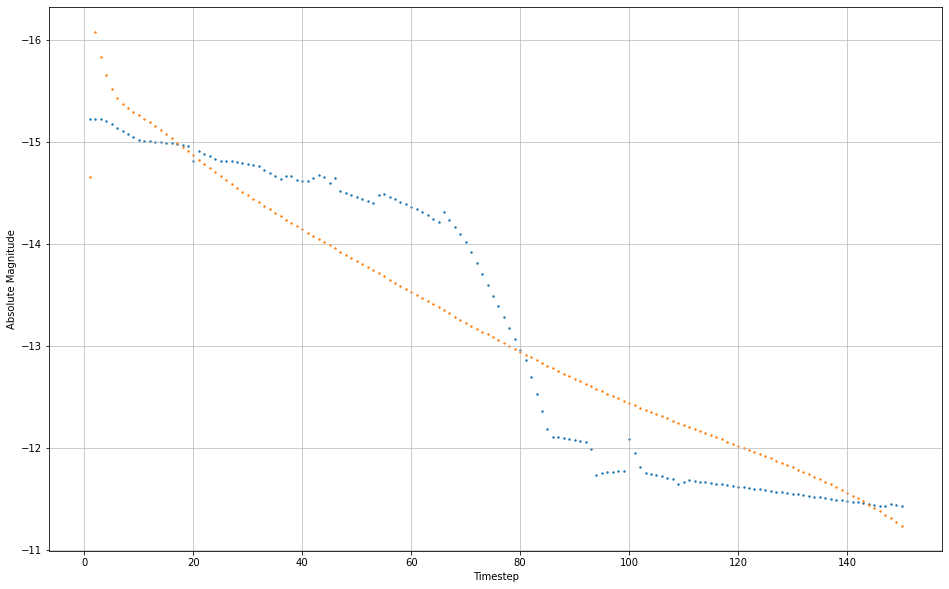

the claimed type is Ia


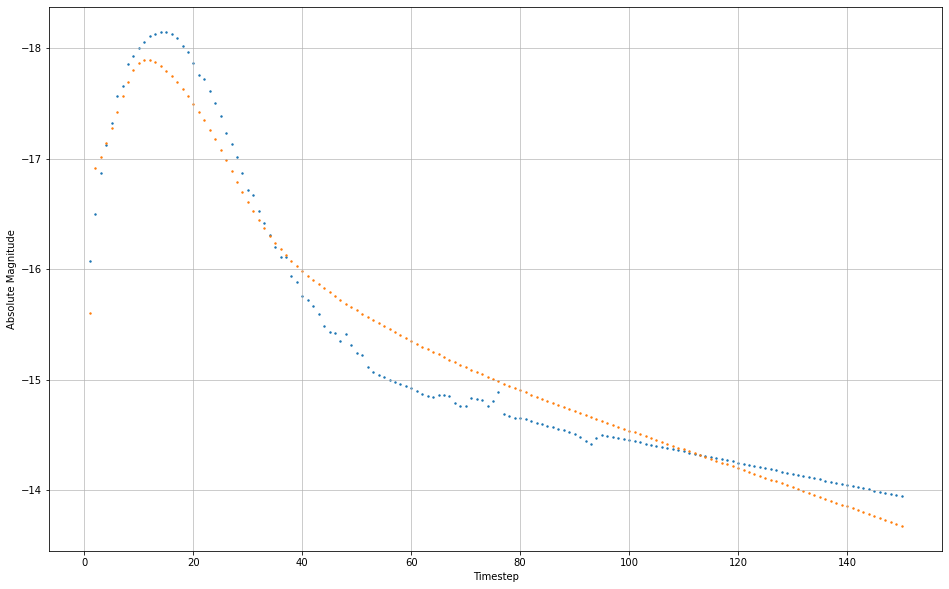

the claimed type is II


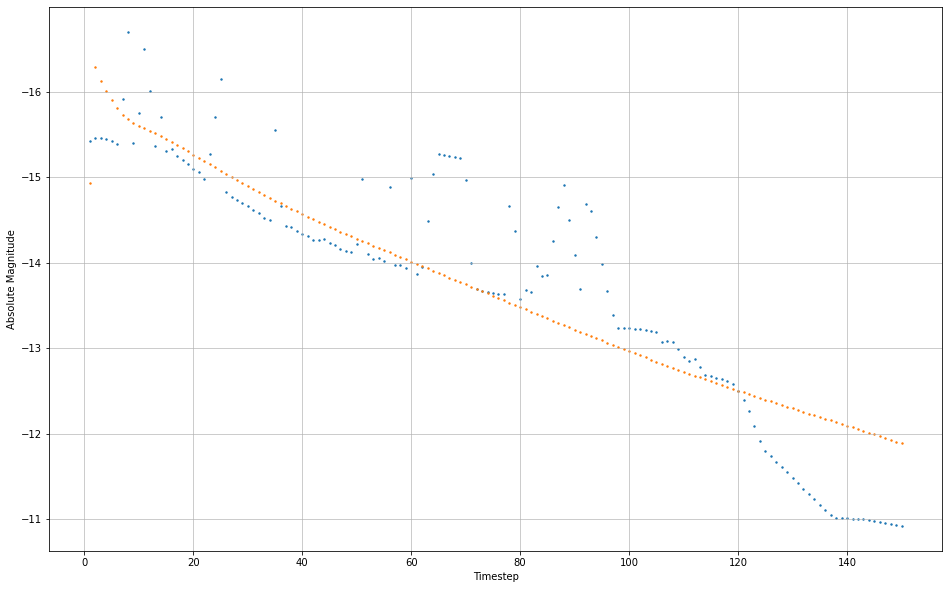

the claimed type is II


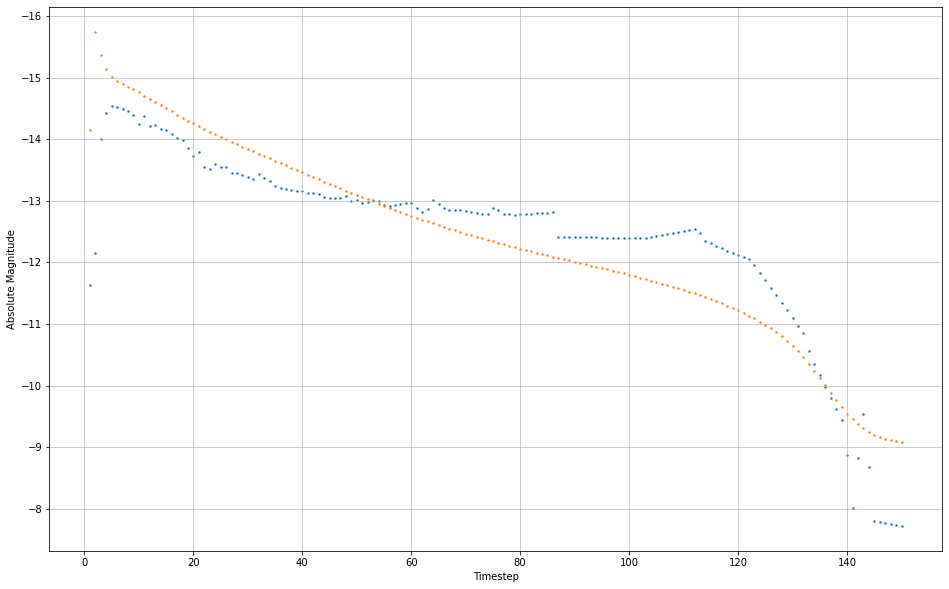

the claimed type is Ia


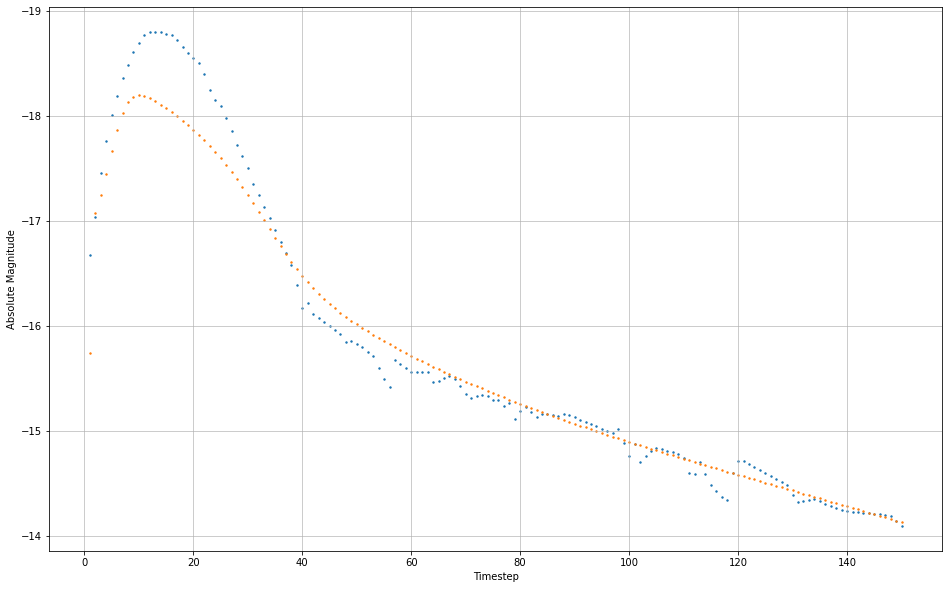

the claimed type is Ia


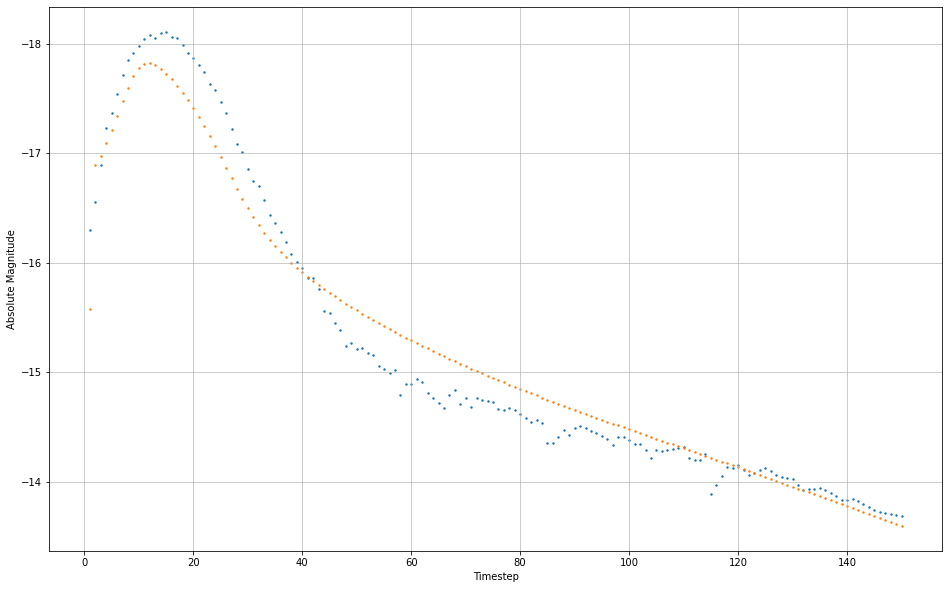

the claimed type is II


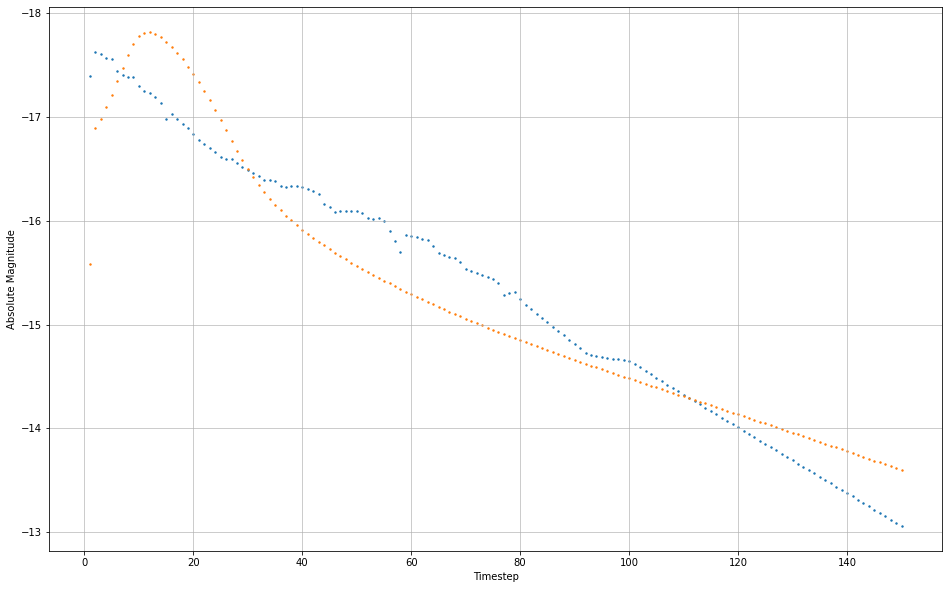

the claimed type is Ia


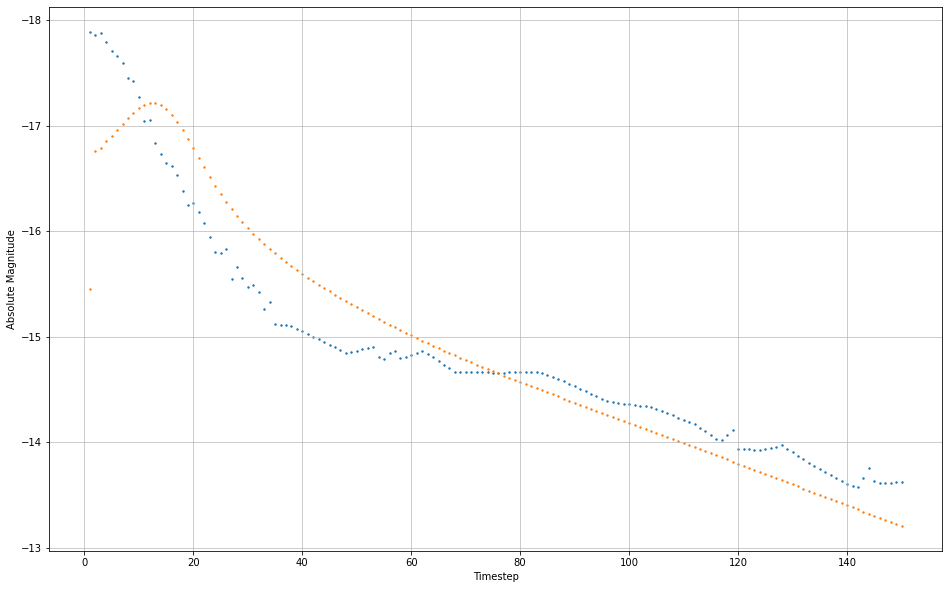

the claimed type is Ia


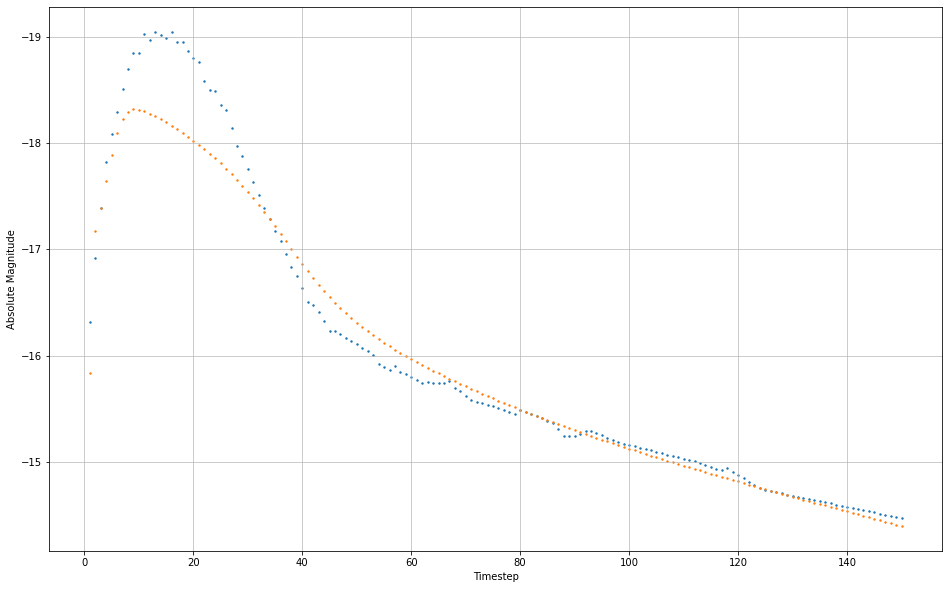

the claimed type is Ia


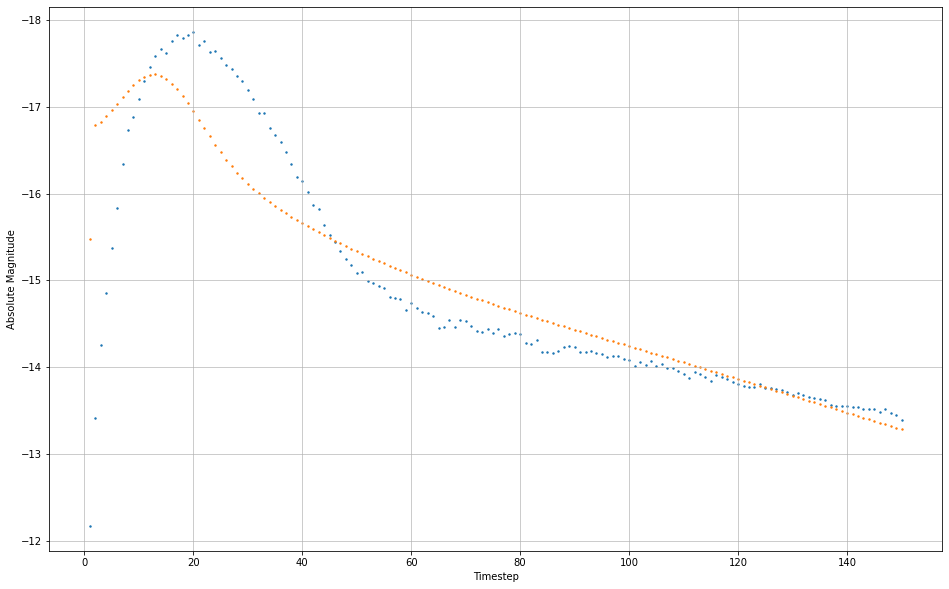

the claimed type is II P


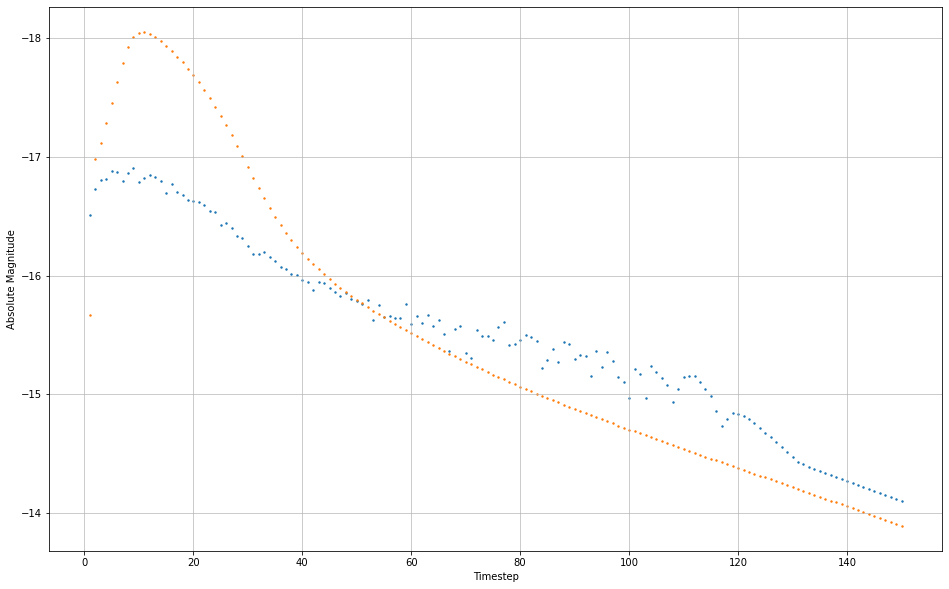

the claimed type is Ia


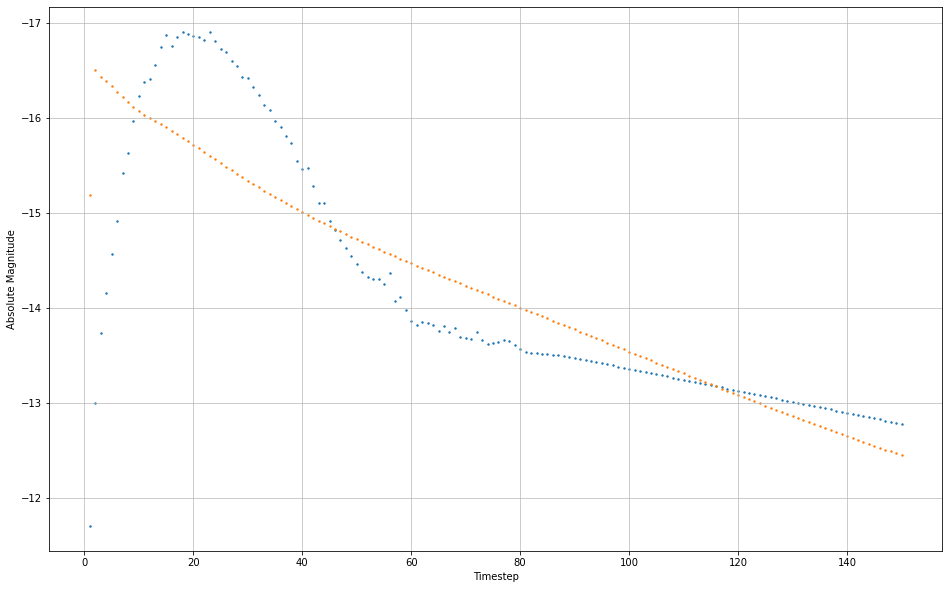

the claimed type is Ia


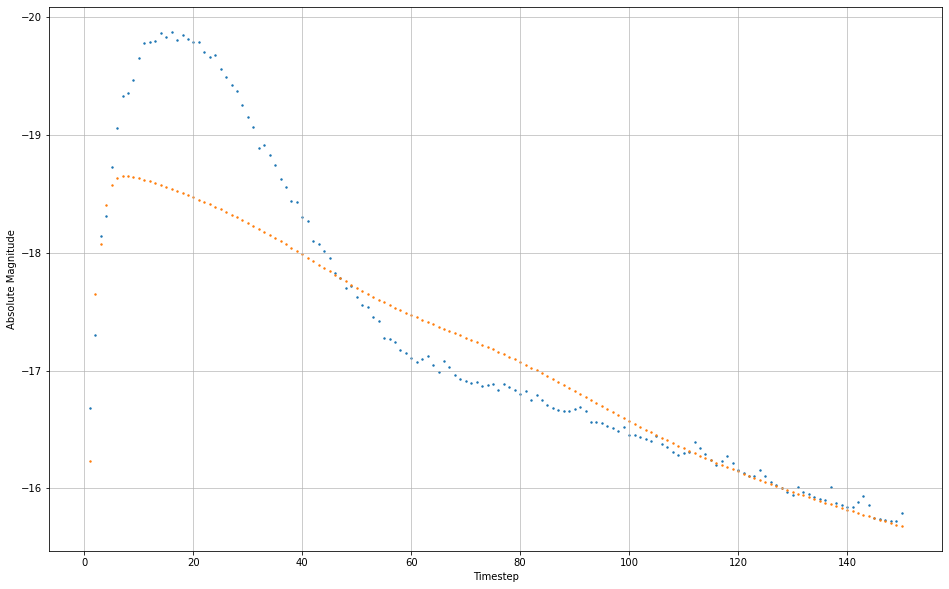

the claimed type is Ia


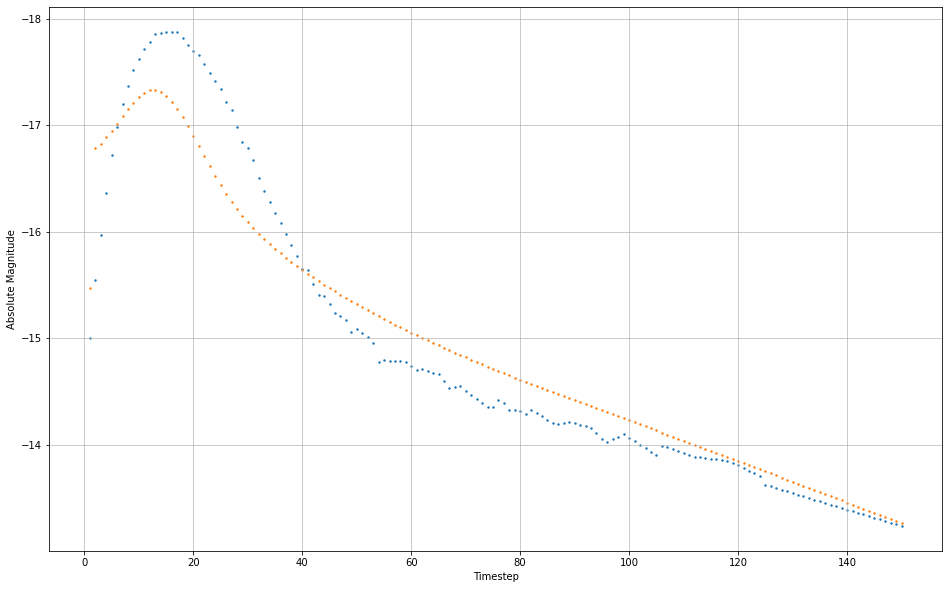

the claimed type is Ia


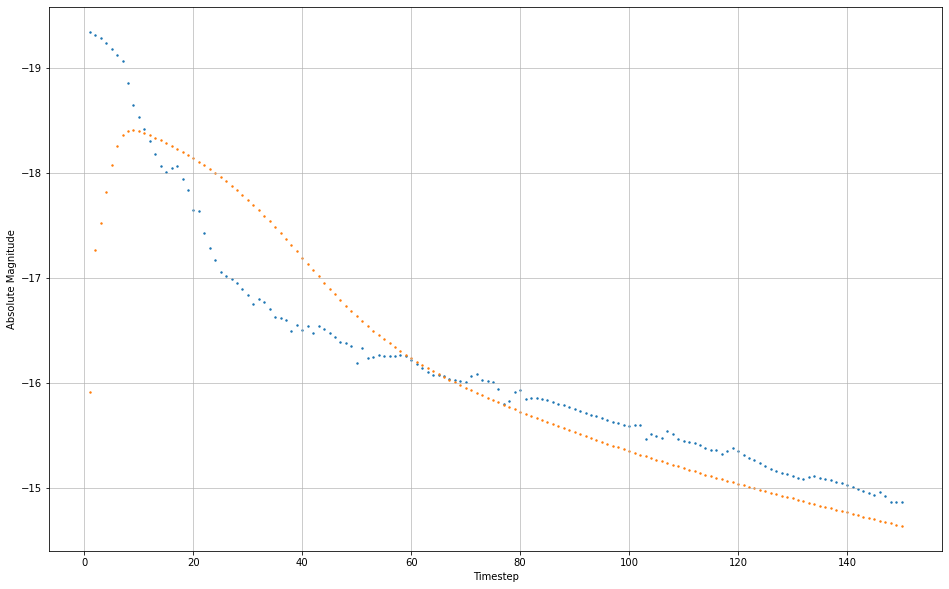

the claimed type is II P


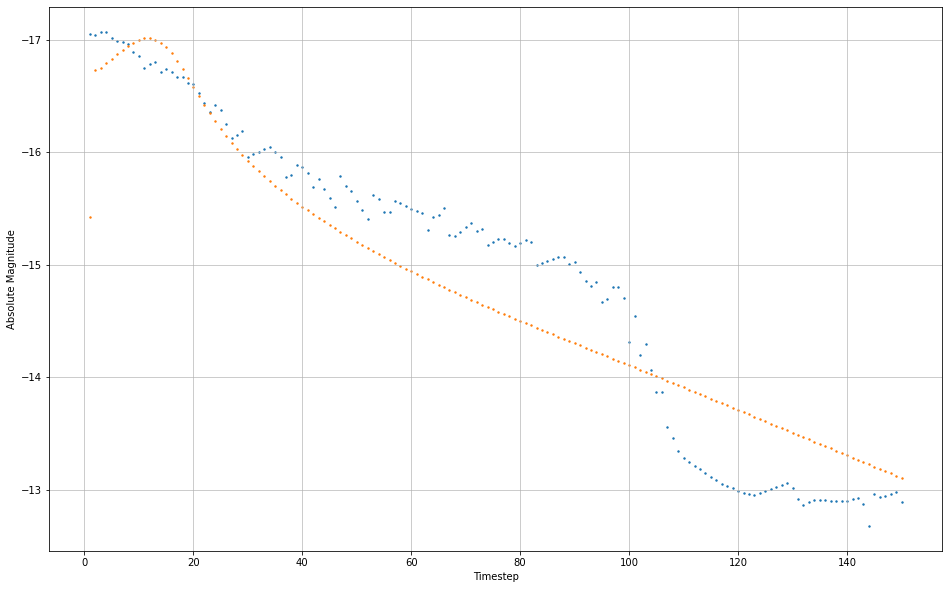

the claimed type is II


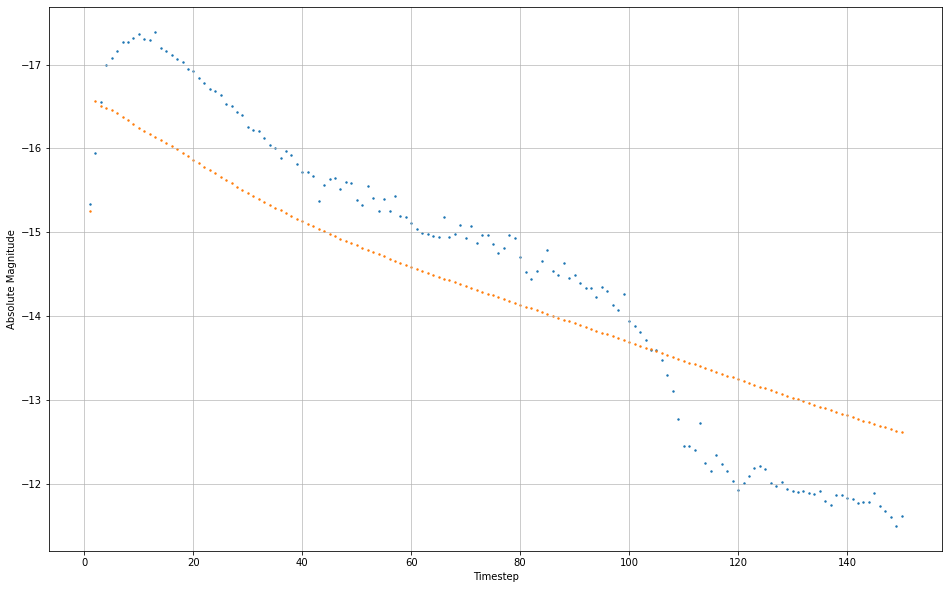

the claimed type is II P


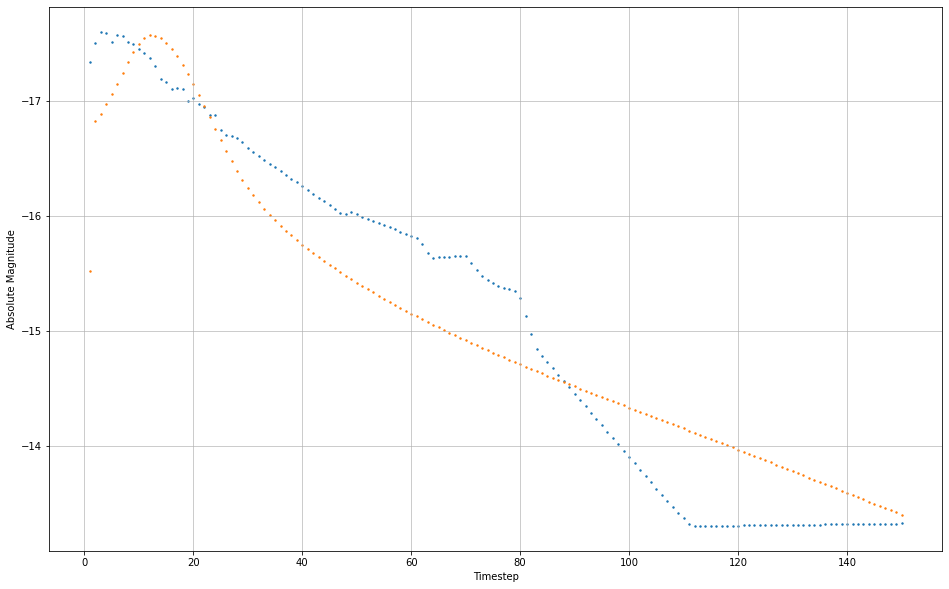

the claimed type is II P


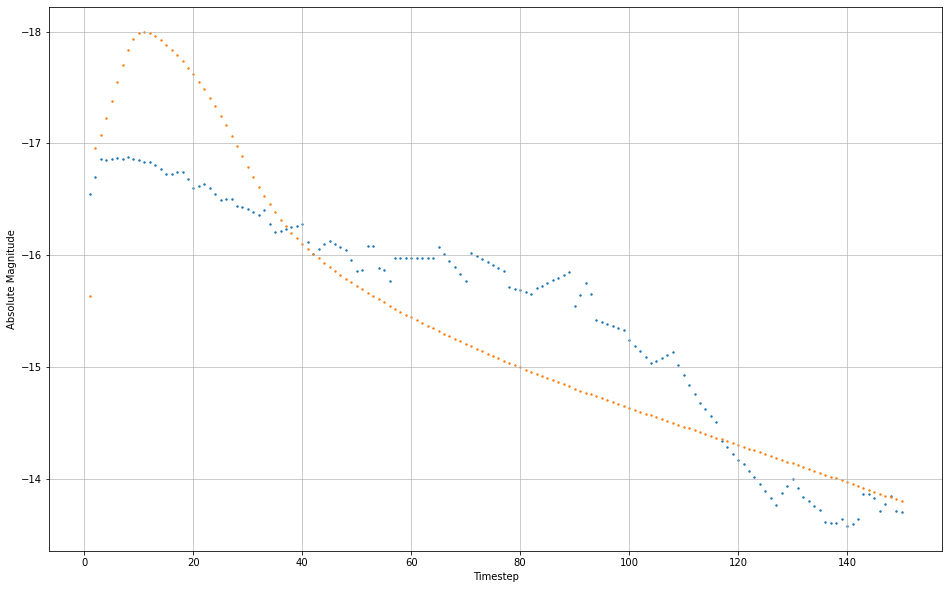

the claimed type is II


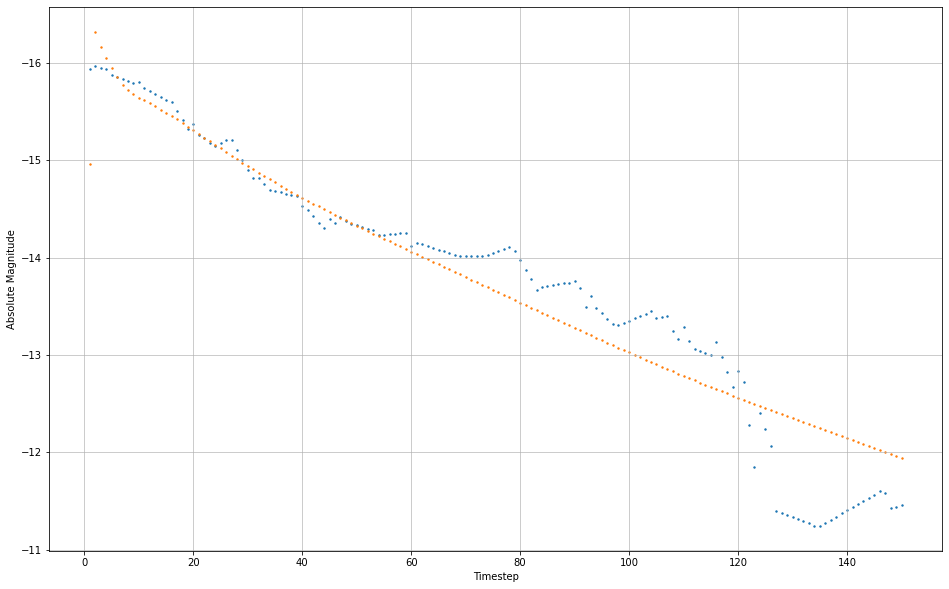

the claimed type is Ia


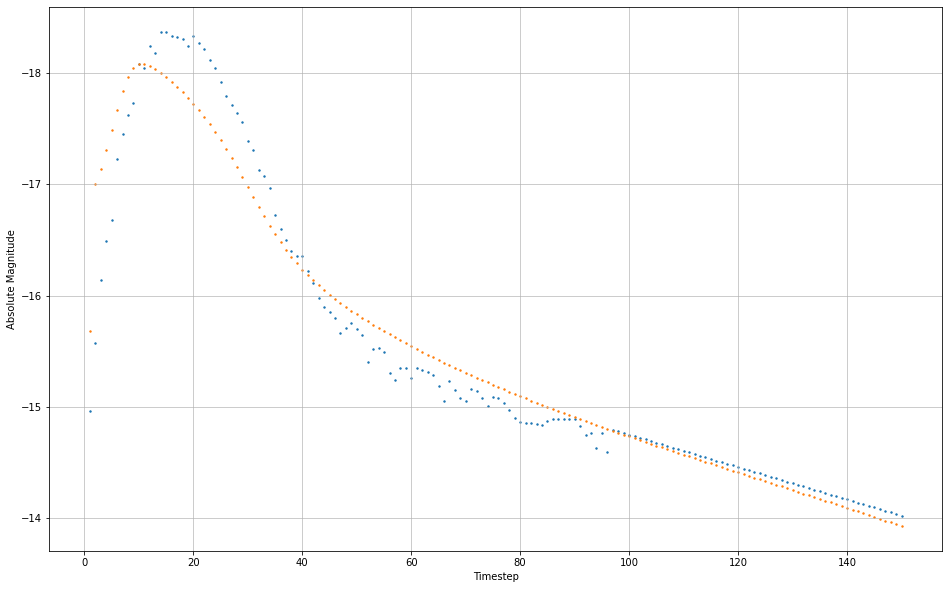

the claimed type is Ia


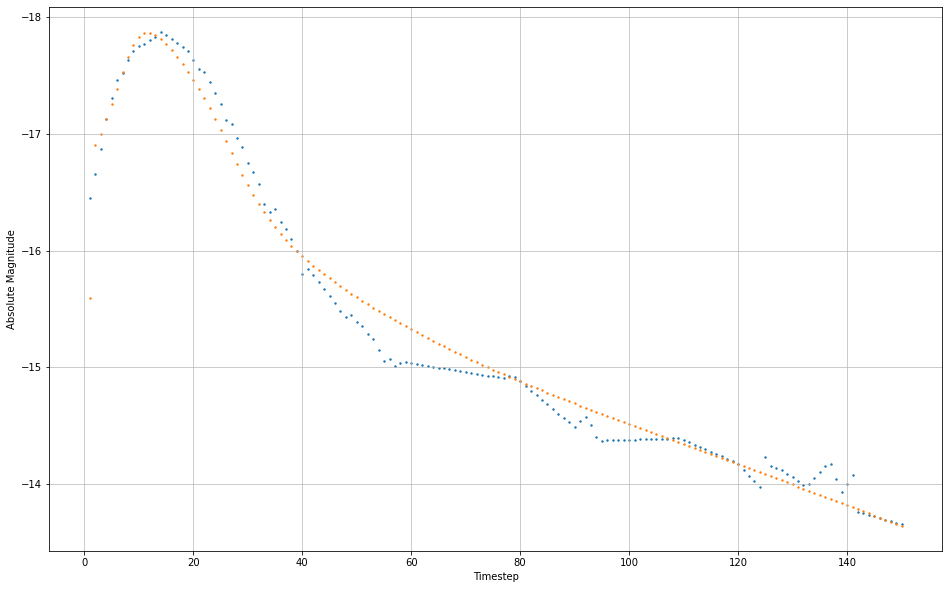

the claimed type is II P


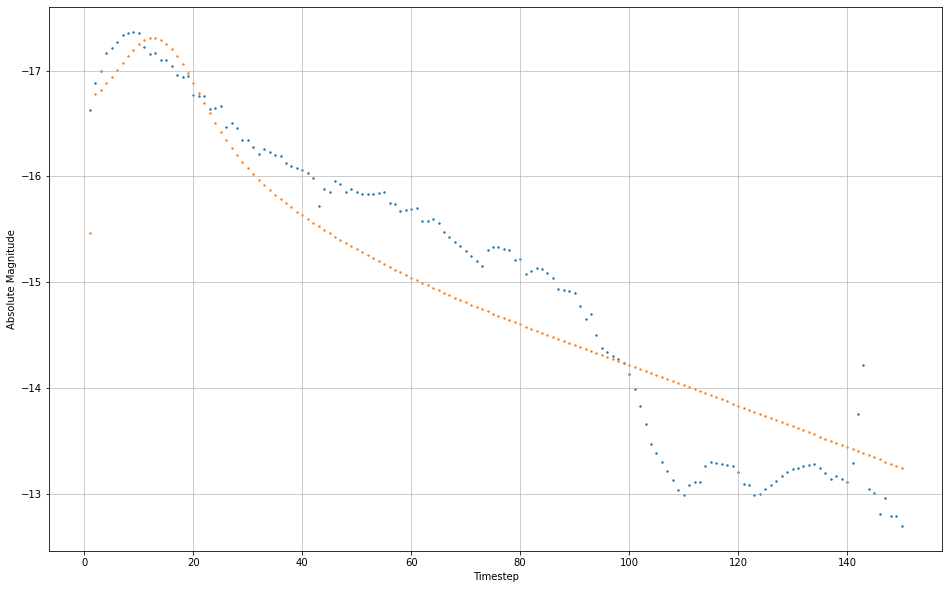

the claimed type is II P


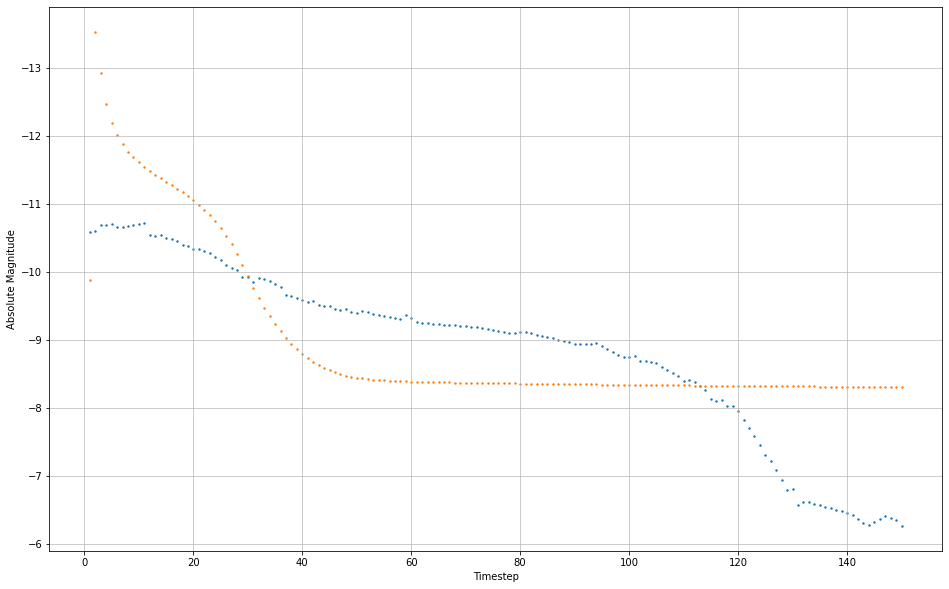

the claimed type is Ia


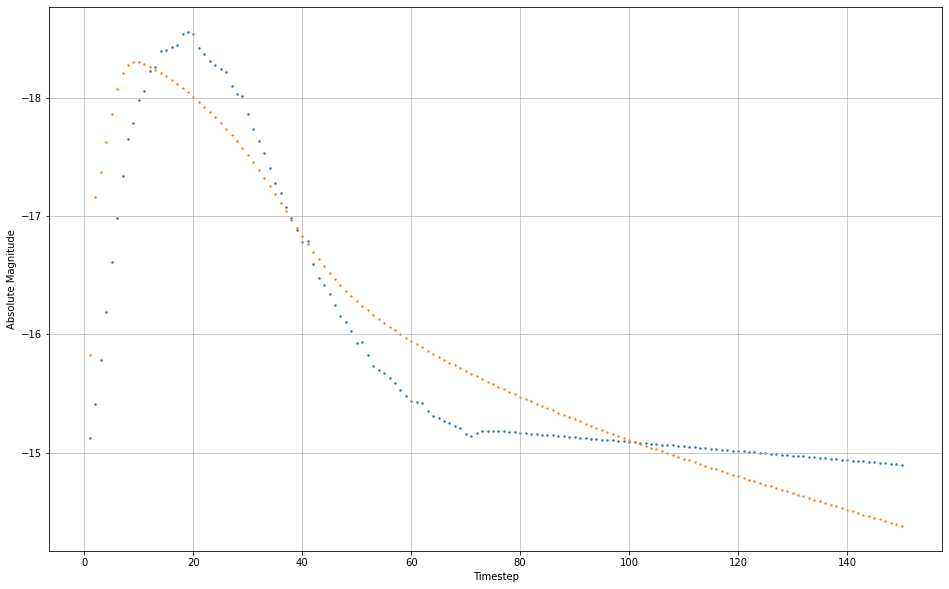

the claimed type is Ia


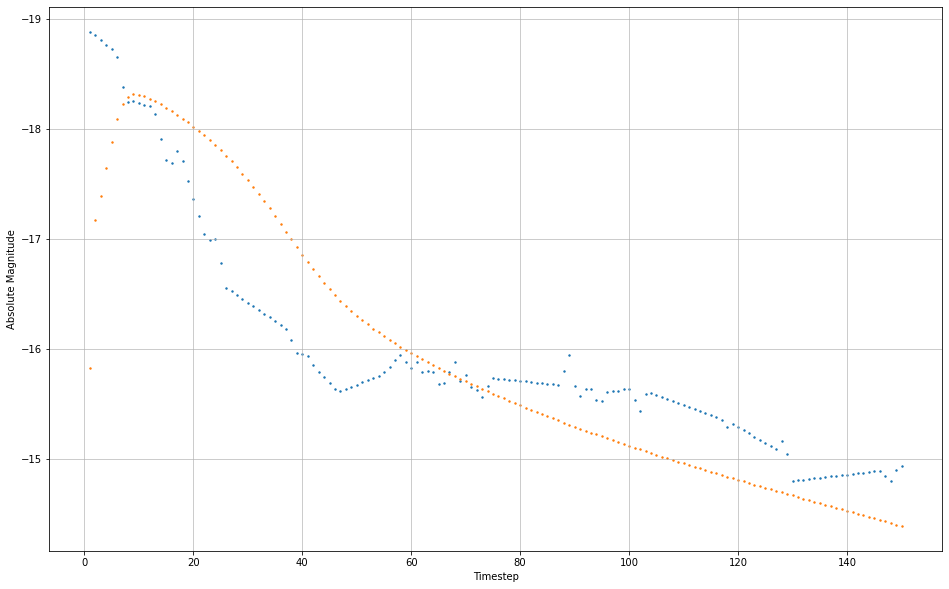

In [170]:
j = 0

for i in range(len(filename)):
    if lightcurve_succ[i] == 1:
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(1, 1, 1)

        plt.gca().invert_yaxis()

        # And a corresponding grid
        ax.grid(which='major', alpha=0.8)
        ax.grid(which='minor', alpha=0.3)

        plt.xlabel('Timestep')
        plt.ylabel('Absolute Magnitude')

        x = np.linspace(1, steps, steps)

        plt.scatter(x, lightcurve[j,:,0], s=2)
        plt.scatter(x, yhat[j,:,0], s=2)
        #plt.scatter(x, yhat1[j,:,0], s=2)
        
        print('the claimed type is', Type[i])
        
        plt.show()
        
        j += 1